# Lyapunov experiments

Notebook for Lyapunov experiments.

**Author:** [Benjamin Carrel](benjamin.carrel@unige.ch)

## Robust to stiffness - 1st example

### Setup the problem

In [ ]:
# Imports
import numpy as np
import numpy.linalg as la
import scipy.sparse.linalg as spala
import time
import datetime
from parameters import *
from low_rank_toolbox import LowRankMatrix, SVD
from problems import make_lyapunov_heat_square_dirichlet
from matrix_ode_toolbox.integrate import solve_matrix_ivp
from matrix_ode_toolbox.dlra import solve_dlra

# Problem parameters
size = 128
t_span = (0, 1)
make_ode = make_lyapunov_heat_square_dirichlet
ode, X0 = make_ode(size)

# Print the ode
print(ode)

### Setup the solvers

In [ ]:
# The sizes
sizes = [32, 64, 96, 128] #, 192, 256, 384, 512]

# Other parameters
nb_steps = 100
ts = np.linspace(t_span[0], t_span[1], nb_steps+1)
rank = 20

# Define the methods (projector splitting comparison)
dlra_solvers = ['KSL', 'unconventional', 'low_rank_splitting', 'PERK']
krylov_kwargs = {'size': 1, 'kind': 'extended', 'is_symmetric': True} # this is overwritten later
substep_kwargs = {'solver': 'explicit_runge_kutta', 'order': 4, 'nb_substeps': 1000}
methods_kwargs = [{'order': 1, 'substep_kwargs': substep_kwargs},
                {'substep_kwargs': substep_kwargs},
                {'order': 1},
                {'order': 1, 'krylov_kwargs': krylov_kwargs}]

## PREALLOCATE THE ERRORS
approx_errors = np.zeros(len(sizes))
cond_numbers = np.zeros(len(sizes))
errors = np.zeros((len(sizes), len(dlra_solvers)))
times = np.zeros((len(sizes), len(dlra_solvers)))

### Run the solvers

In [ ]:
## LOOP OVER THE SIZES
for i, n in enumerate(sizes):
    ## MAKE THE ODE
    print('*********************************************************************************')
    print("Solving for n = {}".format(n))
    ode, X0 = make_ode(n)
    X0 = SVD.reduced_svd(X0)
    Y0 = SVD.truncated_svd(X0, rank)
    cond_numbers[i] = la.cond(ode.A.todense())

    ## COMPUTE REFERENCE SOLUTION
    X1 = solve_matrix_ivp(ode, t_span, X0, solver="closed_form", t_eval=ts, monitor=True, dense_output=True).X1
    approx_errors[i] = np.linalg.norm(X1 - SVD.truncated_svd(X1, rank).todense(), 'fro') / np.linalg.norm(X1, 'fro')

    ## LOOP OVER THE METHODS
    for j, method in enumerate(dlra_solvers):
        # COMPUTE THE SOLUTION WITH THE CURRENT METHOD
        try:
            t0 = time.time()
            Y1 = solve_dlra(ode, t_span, Y0, dlra_solver=method, t_eval=ts, monitor=True, solver_kwargs=methods_kwargs[j]).X1
            times[i, j] = time.time() - t0

            # COMPUTE THE RELATIVE ERROR
            errors[i, j] = np.linalg.norm(Y1.todense() - X1, 'fro') / np.linalg.norm(X1, 'fro')
        except:
            # Some methods may not work for stiff problems
            errors[i, j] = 1e10

### Plot the results

In [ ]:
# Plot the errors
fig1 = plt.figure()
method_names = ['Projector-splitting (Lie-Trotter)', 'Unconventional', 'Low-rank splitting (Lie-Trotter)', 'New method (order 1)']
styles = ['-v', '-^', '-o', '-+']
for j, method in enumerate(dlra_solvers):
    plt.semilogy(sizes, errors[:, j], styles[j], label=method_names[j])
plt.semilogy(sizes, approx_errors, '--', label=f'Best approx. error ($r={rank}$)')
# plt.semilogy(sizes, 1e-10*cond_numbers, '-k', label=r'Cond. number of A ($\times 10^{-10}$)')
plt.tight_layout()
plt.xticks(sizes, sizes)
plt.legend()
plt.grid()
plt.ylim([1e-18, 1e0])
plt.xlabel("Size (mesh refinement)")
plt.ylabel("Relative error in Frobenius norm")
plt.show()

if do_save:
    timestamp = datetime.datetime.now().strftime("%Y%m%d%H%M%S")
    fig1.savefig(f'figures/lyapunov_stiffness_test1_error_{timestamp}.pdf')

# # Plot the performance
# fig2 = plt.figure()
# for j, method in enumerate(dlra_solvers):
#     plt.semilogy(sizes, times[:, j], styles[j], label=method_names[j])
# plt.tight_layout()
# plt.legend()
# plt.xlabel("Size (mesh refinement)")
# plt.xticks(sizes, sizes)
# plt.ylabel("Time of computation (s)")
# plt.grid()
# plt.show()

# if do_save:
#     fig2.savefig('figures/lyapunov_stiffness_test1_time.pdf')

## Robust to stiffness - 2nd example

### Setup the problem

In [ ]:
# Imports
import numpy as np
import numpy.linalg as la
import scipy.sparse.linalg as spala
import time
import datetime
from parameters import *
from low_rank_toolbox import LowRankMatrix, SVD
from problems import make_lyapunov_heat_square_with_time_dependent_source
from matrix_ode_toolbox.integrate import solve_matrix_ivp
from matrix_ode_toolbox.dlra import solve_dlra

# Problem parameters
size = 128
t_span = (0, 1)
make_ode = make_lyapunov_heat_square_with_time_dependent_source
ode, X0 = make_ode(size)

# Print the ode
print(ode)

### Setup the solvers

In [ ]:
# The sizes
sizes = [32, 64, 96, 128, 160, 192]

# Other parameters
nb_steps = 1000
ts = np.linspace(t_span[0], t_span[1], nb_steps+1)
rank = 8

# Define the methods (low-rank splitting comparison)
dlra_solvers = ['PERK', 'PERK', 'low_rank_splitting', 'low_rank_splitting']
krylov_kwargs = {'size': 1, 'kind': 'extended', 'is_symmetric': True}
methods_kwargs = [{'order': 1, 'krylov_kwargs': krylov_kwargs},
                  {'order': 2, 'krylov_kwargs': krylov_kwargs, 'strict_order_conditions': True},
                  {'order': 1}, 
                  {'order': 2}]

## PREALLOCATE THE ERRORS
approx_errors = np.zeros(len(sizes))
cond_numbers = np.zeros(len(sizes))
errors = np.zeros((len(sizes), len(dlra_solvers)))
times = np.zeros((len(sizes), len(dlra_solvers)))

### Run the solvers

In [ ]:
## LOOP OVER THE SIZES
for i, n in enumerate(sizes):
    ## MAKE THE ODE
    print('*********************************************************************************')
    print("Solving for n = {}".format(n))
    ode, X0 = make_ode(n)
    X0 = SVD.reduced_svd(X0)
    Y0 = SVD.truncated_svd(X0, rank)
    cond_numbers[i] = la.cond(ode.A.todense())

    ## COMPUTE REFERENCE SOLUTION
    X1 = solve_matrix_ivp(ode, t_span, X0, solver="automatic", t_eval=ts, monitor=True, dense_output=True).X1
    approx_errors[i] = np.linalg.norm(X1 - SVD.truncated_svd(X1, rank).todense(), 'fro') / np.linalg.norm(X1, 'fro')

    ## LOOP OVER THE METHODS
    for j, method in enumerate(dlra_solvers):
        # COMPUTE THE SOLUTION WITH THE CURRENT METHOD
        try:
            t0 = time.time()
            Y1 = solve_dlra(ode, t_span, Y0, dlra_solver=method, t_eval=ts, monitor=True, solver_kwargs=methods_kwargs[j]).X1
            times[i, j] = time.time() - t0

            # COMPUTE THE RELATIVE ERROR
            errors[i, j] = np.linalg.norm(Y1.todense() - X1, 'fro') / np.linalg.norm(X1, 'fro')
        except:
            # Some methods may not work for stiff problems
            errors[i, j] = 1e10

### Plot the results

In [ ]:
# Plot the errors
fig1 = plt.figure()
method_names = ['Proj. exponential Euler', 'Proj. exponential Runge', 'Low-rank splitting (Lie-Trotter)', 'Low-rank splitting (Strang)']
styles = ['-o', '-s', '-+', '-x']
for j, method in enumerate(dlra_solvers):
    plt.semilogy(sizes, errors[:, j], styles[j], label=method_names[j])
plt.semilogy(sizes, approx_errors, '--', label=f'Best approx. error ($r={rank}$)')
# plt.semilogy(sizes, 1e-10*cond_numbers, '-k', label=r'Cond. number of A ($\times 10^{-10}$)')
plt.tight_layout()
plt.xticks(sizes, sizes)
plt.legend()
plt.grid()
plt.ylim([1e-10, 1e0])
plt.xlabel("Size (mesh refinement)")
plt.ylabel("Relative error in Frobenius norm")
plt.show()

if do_save:
    timestamp = datetime.datetime.now().strftime("%Y%m%d%H%M%S")
    fig1.savefig(f'figures/lyapunov_stiffness_test2_error_{timestamp}.pdf')

# Plot the performance
fig2 = plt.figure()
for j, method in enumerate(dlra_solvers):
    plt.semilogy(sizes, times[:, j], styles[j], label=method_names[j])
plt.tight_layout()
plt.legend()
plt.xlabel("Size (mesh refinement)")
plt.xticks(sizes, sizes)
plt.ylabel("Time of computation (s)")
plt.grid()
plt.show()

if do_save:
    timestamp = datetime.datetime.now().strftime("%Y%m%d%H%M%S")
    fig2.savefig(f'figures/lyapunov_stiffness_test2_time_{timestamp}.pdf')

## Compare the methods - Global error and performance

### Setup the problem

In [ ]:
# Imports
import numpy as np
import scipy.sparse.linalg as spala
import time
import datetime
from parameters import *
from low_rank_toolbox import LowRankMatrix, SVD
from problems import make_lyapunov_heat_square_with_time_dependent_source
from matrix_ode_toolbox.integrate import solve_matrix_ivp
from matrix_ode_toolbox.dlra import solve_dlra

# Problem parameters
size = 128 # 128
t_span = (0, 1) # (0, 1)
make_ode = make_lyapunov_heat_square_with_time_dependent_source
ode, X0 = make_ode(size)

# Print the ode
print(ode)

# Preprocess the problem
if not isinstance(X0, LowRankMatrix):
    X0 = SVD.reduced_svd(X0)
invA = spala.splu(ode.A).solve
invB = spala.splu(ode.B).solve

### Setup the solvers

In [ ]:
# DLRA parameters
rank = 16
Y0 = X0.truncate(rank)

# Methods parameters - ALL PERK
nb_steps = np.logspace(1, 3, 6, dtype=int)
stepsizes = t_span[1] / nb_steps
dlra_solvers = ['PERK', 'PERK', 'PERK']
krylov_kwargs = {'size': 1,
                 'kind': 'extended',
                 'is_symmetric': True,
                 'invA': invA,
                 'invB': invB}
methods_kwargs = [{'order': 1, 'krylov_kwargs': krylov_kwargs},
                  {'order': 2, 'krylov_kwargs': krylov_kwargs, 'strict_order_conditions': True},
                  {'order': 2, 'krylov_kwargs': krylov_kwargs, 'strict_order_conditions': False}]

## Pre-allocate some variables
global_errors = np.zeros((len(nb_steps), len(dlra_solvers)))
times = np.zeros((len(nb_steps), len(dlra_solvers)))

### Run the solvers

In [ ]:
for i, nb in enumerate(nb_steps):
    print('*************************************************************************')
    print(f'Solving with {nb} steps. ({i+1}/{len(nb_steps)})')
    t_eval = np.linspace(*t_span, nb+1)

    # Compute the reference solution
    X1 = solve_matrix_ivp(ode, t_span, X0, solver="automatic", t_eval=t_eval, dense_output=True, monitor=True, scipy_method='RK45').X1
    
    # Loop over the methods
    for j, method in enumerate(dlra_solvers):
        # Compute the solution with the current method
        t0 = time.time()
        Y1 = solve_dlra(ode, t_span, Y0, dlra_solver=method, t_eval=t_eval, monitor=True, solver_kwargs=methods_kwargs[j]).X1
        times[i, j] = time.time() - t0

        # Compute the relative error
        global_errors[i, j] = np.linalg.norm(Y1.todense() - X1, 'fro') / np.linalg.norm(X1, 'fro')

# Approximate error
approx_error = np.linalg.norm(X1 - SVD.truncated_svd(X1, rank).todense(), 'fro') / np.linalg.norm(X1, 'fro')


### Plot the comparison between all three methods

In [ ]:
# Plot the errors
fig1 = plt.figure()
method_names = ['Proj. exponential Euler',  'Proj. exponential Runge (strict)', 'Proj. exponential Runge (non strict)']
styles = ['-o', '-x', '-p']
plt.loglog(stepsizes, global_errors[:, 0], styles[0], label=method_names[0])
plt.loglog(stepsizes, global_errors[:, 1], styles[1], label=method_names[1])
plt.loglog(stepsizes, global_errors[:, 2], styles[2], label=method_names[2])
plt.loglog(stepsizes, 4*stepsizes, 'k') # , label=r'$O(h)$'
plt.loglog(stepsizes, 4*stepsizes**2, 'k') # , label=r'$O(h^2)$'
plt.axhline(approx_error, linestyle='--', color='gray', label=f'Best approx. error ($r={rank}$)')
plt.legend(loc='upper left')
plt.grid()
plt.xlabel("Step size")
plt.ylabel("Relative error in Frobenius norm")
plt.ylim([1e-9, 1e3])
plt.show()



if do_save == True:
    timestamp = datetime.datetime.now().strftime("%Y%m%d%H%M%S")
    fig1.savefig(f'figures/lyapunov_three_methods_convergence_{timestamp}.pdf')

# Plot the performance
fig2 = plt.figure()
plt.loglog(global_errors[:, 0], times[:, 0], styles[0], label=method_names[0])
plt.loglog(global_errors[:, 1], times[:, 1], styles[1], label=method_names[1])
plt.loglog(global_errors[:, 2], times[:, 2], styles[2], label=method_names[2])
plt.axvline(approx_error, linestyle='--', color='gray', label=f'Best approx.error ($r={rank}$)')
plt.legend(loc='upper left')
plt.gca().invert_xaxis()
plt.grid()
plt.xlabel("Relative error in Frobenius norm")
plt.ylabel("Time of computation (s)")
plt.show()

if do_save == True:
    timestamp = datetime.datetime.now().strftime("%Y%m%d%H%M%S")
    fig2.savefig(f'figures/lyapunov_three_methods_performance_{timestamp}.pdf')


# Do a table with convergence rates for the different methods by computing the ratio between two consecutive errors
print('Step size & Proj. exp. Euler & Proj. exp. Runge (strict) & Proj. exp. Runge (non strict) \\\\')
print('\\hline')
# 
for i in range(len(stepsizes)):
    if i == 0:
        print(f'- & - & - & - \\\\')
    else:
        print(f'h={stepsizes[i]:.5f}' + f'& {np.log(global_errors[i-1, 0] / global_errors[i, 0]) / np.log(stepsizes[i-1] / stepsizes[i]):.3f} & {np.log(global_errors[i-1, 1] / global_errors[i, 1]) / np.log(stepsizes[i-1] / stepsizes[i]):.3f} & {np.log(global_errors[i-1, 2] / global_errors[i, 2]) / np.log(stepsizes[i-1] / stepsizes[i]):.3f} \\\\')




## Compare the ranks - Global error and performance

### Setup the problem

In [ ]:
# Imports
import numpy as np
import scipy.sparse.linalg as spala
import time
import datetime
from parameters import *
from low_rank_toolbox import LowRankMatrix, SVD
from problems import make_lyapunov_heat_square_with_time_dependent_source
from matrix_ode_toolbox.integrate import solve_matrix_ivp
from matrix_ode_toolbox.dlra import solve_dlra

# Problem parameters
size = 128
t_span = (0, 1)
make_ode = make_lyapunov_heat_square_with_time_dependent_source
ode, X0 = make_ode(size)

# Print the ode
print(ode)

# Preprocess the problem
if not isinstance(X0, LowRankMatrix):
    X0 = SVD.reduced_svd(X0)
invA = spala.splu(ode.A).solve
invB = spala.splu(ode.B).solve

### Setup the solver and other parameters

In [ ]:
# Method parameters - PERK
method = 'PERK'
invA = spala.inv(ode.A).dot
invB = spala.inv(ode.B).dot
krylov_kwargs = {'size': 1, 
                 'kind': 'extended', 
                 'is_symmetric': True, 
                 'invA': invA, 
                 'invB': invB}
method_kwargs = {'order': 2, 
                 'krylov_kwargs': krylov_kwargs, 
                 'strict_order_conditions': True}

# Ranks to test
ranks = [4, 7, 11, 16]

# Number of steps
list_nb_steps = np.logspace(1, 5, 10, dtype=int)

# Preallocation
global_errors = np.zeros((len(list_nb_steps), len(ranks)))
approx_error = np.zeros((len(list_nb_steps), len(ranks)))
times = np.zeros((len(list_nb_steps), len(ranks)))

### Run the solver for different ranks

In [ ]:
# Loop over the number of steps
for i, nb in enumerate(list_nb_steps):
    print('*************************************************************************')
    print(f'Solving with {nb} steps. ({i+1}/{len(list_nb_steps)})')
    t_eval = np.linspace(*t_span, nb+1)

    # Compute the reference solution
    X1 = solve_matrix_ivp(ode, t_span, X0, solver="automatic", t_eval=t_eval, dense_output=True, monitor=True).X1

    for rank in ranks:
        print('$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$')
        print(f'Rank {rank}')
        t_eval = np.linspace(*t_span, nb+1)

        # Compute the best rank approximation
        approx_error[i, ranks.index(rank)] = np.linalg.norm(X1 - SVD.truncated_svd(X1, rank).todense(), 'fro') / np.linalg.norm(X1, 'fro')

        # Compute the solution with the DLRA method
        Y0 = SVD.truncated_svd(X0, rank)
        t0 = time.time()
        Y1 = solve_dlra(ode, t_span, Y0, dlra_solver=method, t_eval=t_eval, monitor=True, solver_kwargs=method_kwargs).X1
        times[i, ranks.index(rank)] = time.time() - t0

        # Compute the relative error
        global_errors[i, ranks.index(rank)] = np.linalg.norm(Y1.todense() - X1, 'fro') / np.linalg.norm(X1, 'fro')


### Plot the results

In [ ]:
# Plot the errors
fig1 = plt.figure()
stepsizes = t_span[1] / list_nb_steps
# One color per rank
names = [f'Rank {r}' for r in ranks]
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:purple', 'tab:brown'] # , 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
styles = ['-o', '-s', '-p', '-D']
for j in range(len(ranks)):
    plt.loglog(stepsizes, global_errors[:, j], styles[j], label=names[j], color=colors[j])
    plt.loglog(stepsizes, approx_error[:, j], '--', color=colors[j])
plt.loglog(stepsizes, stepsizes**2, color='k')
plt.legend()
plt.xlabel("Step size")
plt.ylabel("Relative error in Frobenius norm")
plt.ylim(1e-9, 1e-1)
plt.grid()
plt.tight_layout()
plt.show()

if do_save:
    timestamp = datetime.datetime.now().strftime("%Y%m%d%H%M%S")
    fig1.savefig(f'figures/lyapunov_rank_test_error_{datetime}.pdf')


# Plot the performance
fig2 = plt.figure()
for j in range(len(ranks)):
    plt.loglog(global_errors[:, j], times[:, j], styles[j], label=names[j], color=colors[j])
    plt.axvline(approx_error[0, j], linestyle='--', color=colors[j])
plt.legend()
plt.xlabel("Relative error in Frobenius norm")
plt.ylabel("Time of computation (s)")
plt.gca().invert_xaxis()
plt.tight_layout()
plt.grid()
plt.show()

if do_save:
    timestamp = datetime.datetime.now().strftime("%Y%m%d%H%M%S")
    fig2.savefig(f'figures/lyapunov_rank_test_performance_{datetime}.pdf')

## Compare the sizes - Global error and performance

### Setup the problem

In [ ]:
# Imports
import numpy as np
import scipy.sparse.linalg as spala
import time
import datetime
from parameters import *
from low_rank_toolbox import LowRankMatrix, SVD
from problems import make_lyapunov_heat_square_with_time_dependent_source
from matrix_ode_toolbox.integrate import solve_matrix_ivp
from matrix_ode_toolbox.dlra import solve_dlra

# Problem parameters
t_span = (0, 1)
make_ode = make_lyapunov_heat_square_with_time_dependent_source
ode, X0 = make_ode()

# Print the ode
print(ode)

### Setup the solver and other parameters

In [ ]:
# Ranks to test
sizes = [32, 64, 128, 164]

# Number of steps
list_nb_steps = np.logspace(1, 3, 4, dtype=int)

# Preallocation
global_errors_strict = np.zeros((len(list_nb_steps), len(sizes)))
global_errors_non_strict = np.zeros((len(list_nb_steps), len(sizes)))
approx_errors = np.zeros((len(list_nb_steps), len(sizes)))
times_strict = np.zeros((len(list_nb_steps), len(sizes)))
times_non_strict = np.zeros((len(list_nb_steps), len(sizes)))

### Run the solver for different sizes

In [ ]:
## LOOP OVER THE SIZES
for i, n in enumerate(sizes):
    ## MAKE THE ODE
    print('*********************************************************************************')
    print("Solving for n = {}".format(n))
    ode, X0 = make_ode(n)
    rank = 16
    X0 = SVD.reduced_svd(X0)
    Y0 = SVD.truncated_svd(X0, rank)
    # cond_numbers[i] = la.cond(ode.A.todense())

    ## LOOP OVER THE NUMBER OF STEPS
    for j, nb in enumerate(list_nb_steps):
        print('----------------------------------------')
        print(f'Solving with {nb} steps. ({j+1}/{len(list_nb_steps)})')
        ## COMPUTE REFERENCE SOLUTION
        ts = np.linspace(t_span[0], t_span[1], nb+1)
        X1 = solve_matrix_ivp(ode, t_span, X0, solver="automatic", t_eval=ts, monitor=True, dense_output=True).X1
        approx_errors[j, i] = np.linalg.norm(X1 - SVD.truncated_svd(X1, rank).todense(), 'fro') / np.linalg.norm(X1, 'fro')

        ## SOME PREPROCESSING
        invA = spala.inv(ode.A).dot
        invB = spala.inv(ode.B).dot
        krylov_kwargs = {'size': 1, 
                        'kind': 'extended', 
                        'is_symmetric': True, 
                        'invA': invA, 
                        'invB': invB}
        
        ## STRICT ORDER CONDITIONS
        method = 'PERK'
        method_kwargs = {'order': 2,
                        'krylov_kwargs': krylov_kwargs, 
                        'strict_order_conditions': True}
        t0 = time.time()
        Y1 = solve_dlra(ode, t_span, Y0, dlra_solver=method, t_eval=ts, monitor=True, solver_kwargs=method_kwargs).X1
        times_strict[j, i] = time.time() - t0

        global_errors_strict[j, i] = np.linalg.norm(Y1.todense() - X1, 'fro') / np.linalg.norm(X1, 'fro')
        
        ## NON-STRICT ORDER CONDITIONS
        method = 'PERK'
        method_kwargs = {'order': 2, 
                        'krylov_kwargs': krylov_kwargs, 
                        'strict_order_conditions': False}
        t0 = time.time()
        Y1 = solve_dlra(ode, t_span, Y0, dlra_solver=method, t_eval=ts, monitor=True, solver_kwargs=method_kwargs).X1
        times_non_strict[j, i] = time.time() - t0

        global_errors_non_strict[j, i] = np.linalg.norm(Y1.todense() - X1, 'fro') / np.linalg.norm(X1, 'fro')



### Plot the results

In [ ]:
# Plot the errors
fig1 = plt.figure()
stepsizes = t_span[1] / list_nb_steps
# One color per size
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:purple', 'tab:brown'] # , 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
names = [f'n={s}' for s in sizes]
styles = ['-o', '-s', '-p', '-D']
for j, size in enumerate(sizes):
    plt.loglog(stepsizes, global_errors_strict[:, j], '-x', color=colors[j])
    plt.loglog(stepsizes, global_errors_non_strict[:, j], '-p', color=colors[j])
    plt.loglog(stepsizes, approx_errors[:, j], '--', color=colors[j], label=f'Size n={size}')
plt.loglog(stepsizes, stepsizes**2, color='k')
plt.legend()
plt.xlabel("Step size")
plt.ylabel("Relative error in Frobenius norm")
plt.ylim(1e-15, 1e-1)
plt.grid()
plt.tight_layout()
plt.show()

if do_save:
    timestamp = datetime.datetime.now().strftime("%Y%m%d%H%M%S")
    fig1.savefig(f'figures/lyapunov_size_test_error_{timestamp}.pdf')


# Plot the performance
fig2 = plt.figure()
for j, size in enumerate(sizes):
    plt.loglog(global_errors_strict[:, j], times_strict[:, j], '-x', color=colors[j])
    plt.loglog(global_errors_non_strict[:, j], times_non_strict[:, j], '-p', color=colors[j])
    plt.axvline(approx_errors[0, j], linestyle='--', color=colors[j], label=f'Size n={size}')
plt.legend()
plt.xlabel("Relative error in Frobenius norm")
plt.ylabel("Time of computation (s)")
plt.gca().invert_xaxis()
plt.tight_layout()
plt.grid()
plt.show()

if do_save:
    timestamp = datetime.datetime.now().strftime("%Y%m%d%H%M%S")
    fig2.savefig(f'figures/lyapunov_size_test_performance_{timestamp}.pdf')

## Rank-adaptive method

### Setup the problem

In [1]:
# Imports
import numpy as np
import datetime
from parameters import *
from low_rank_toolbox import LowRankMatrix, SVD
from problems import make_lyapunov_heat_square_with_time_dependent_special
from matrix_ode_toolbox.integrate import solve_matrix_ivp
from matrix_ode_toolbox.dlra import solve_adaptive_dlra

# Problem parameters
size = 128 # 128
t_span = (0, 1) # (0, 1)
make_ode = make_lyapunov_heat_square_with_time_dependent_special
ode, X0 = make_ode(size)

# Print the ode
print(ode)
if not isinstance(X0, LowRankMatrix):
    X0 = SVD.reduced_svd(X0)
print('Dimensions: ', X0.shape)

# Precompute reference solution
nb_steps = 1000 # 1000
ts = np.linspace(*t_span, nb_steps+1)
ref_sol = solve_matrix_ivp(ode, t_span, X0, solver="automatic", t_eval=ts, monitor=True)
Xs_ref = ref_sol.todense()

Sylvester-like ODE structure with 3 parameters.
Dimensions:  (128, 128)
----------------------------------------
Scipy solver 
-- RK45 method 
-- 1 substep(s)


Solving matrix ODE: 100%|██████████| 1000/1000 [03:36<00:00,  4.61it/s]


### Plot the singular values

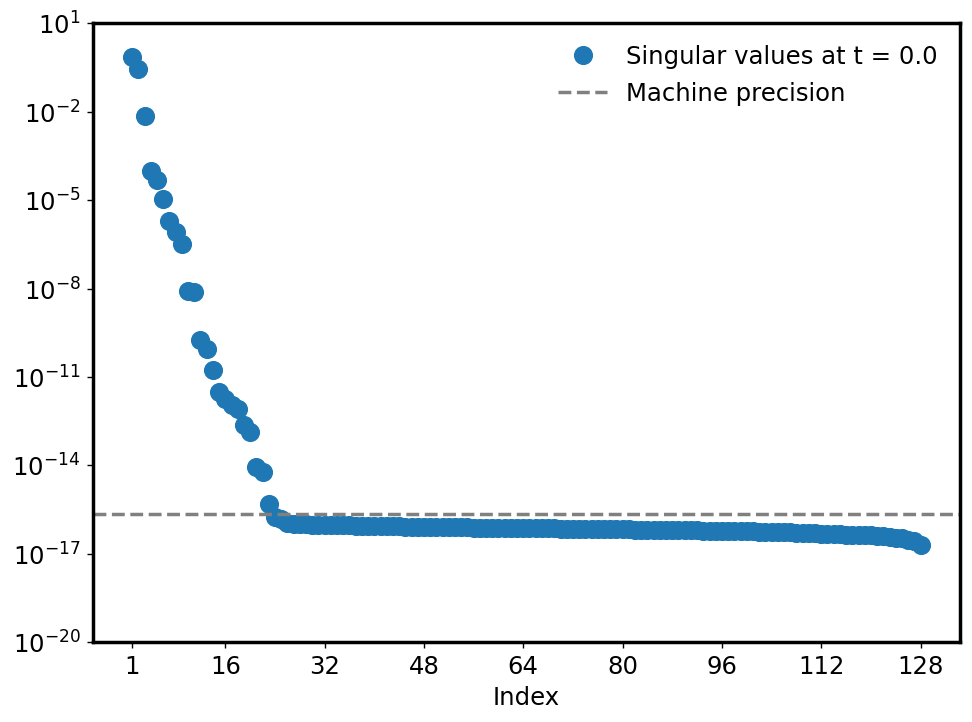

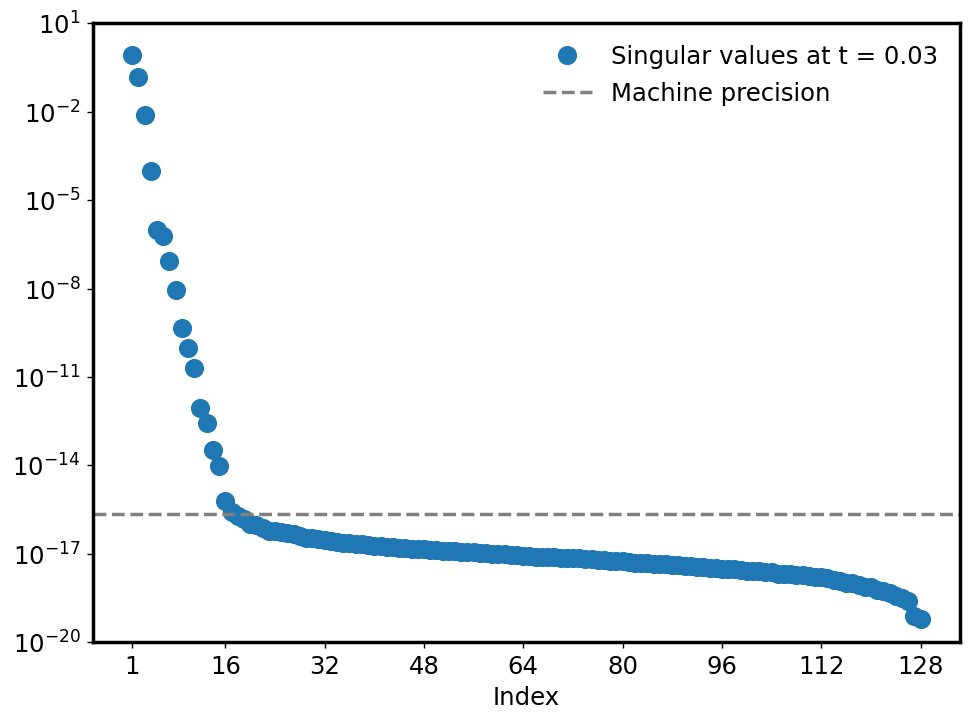

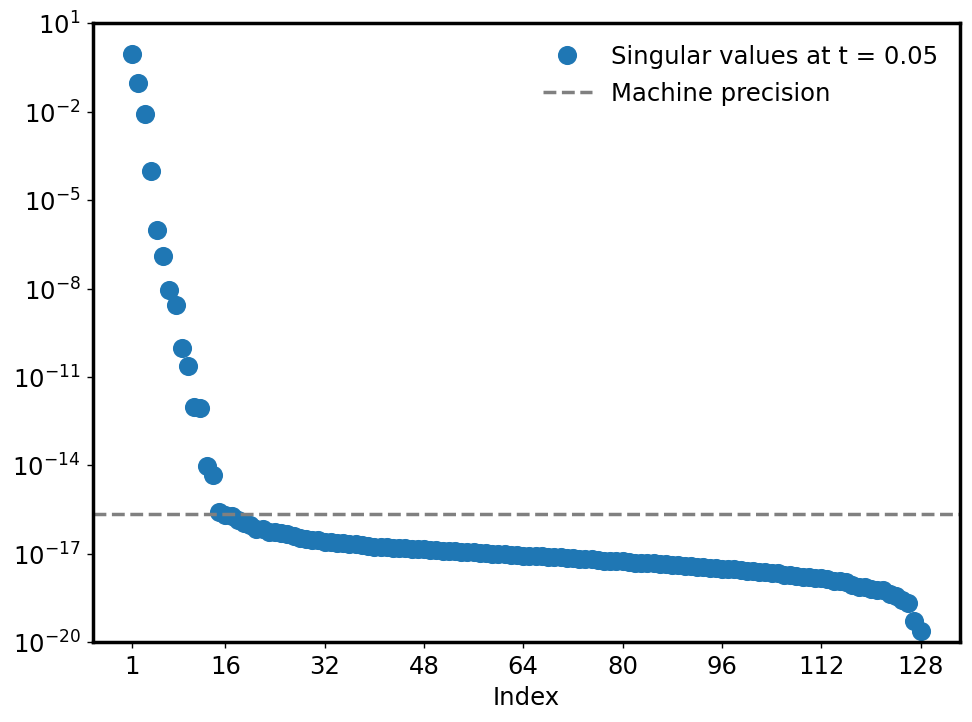

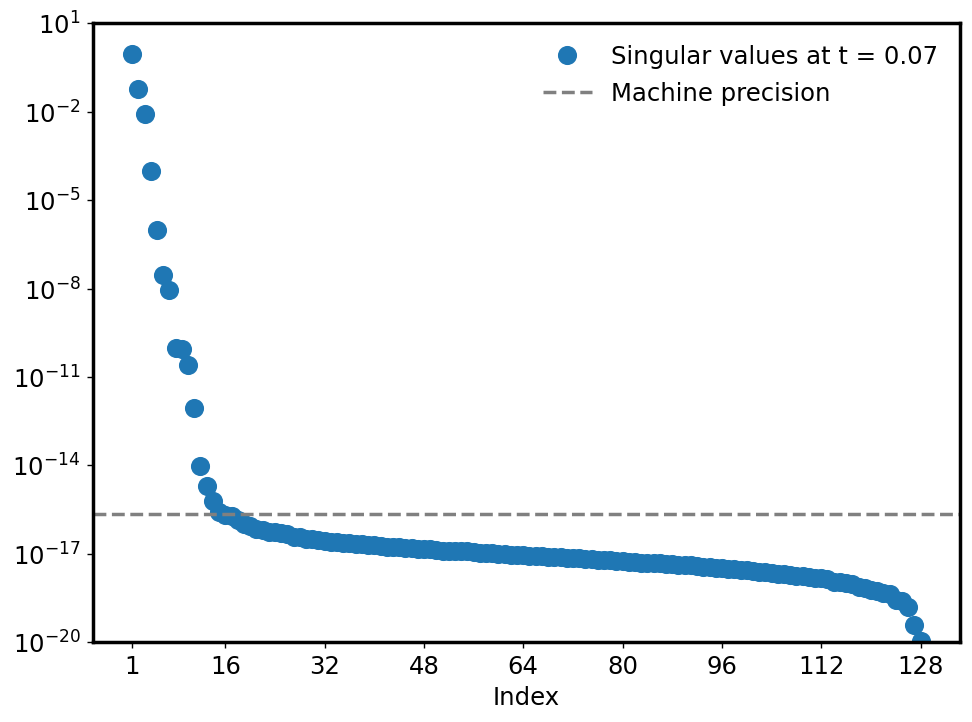

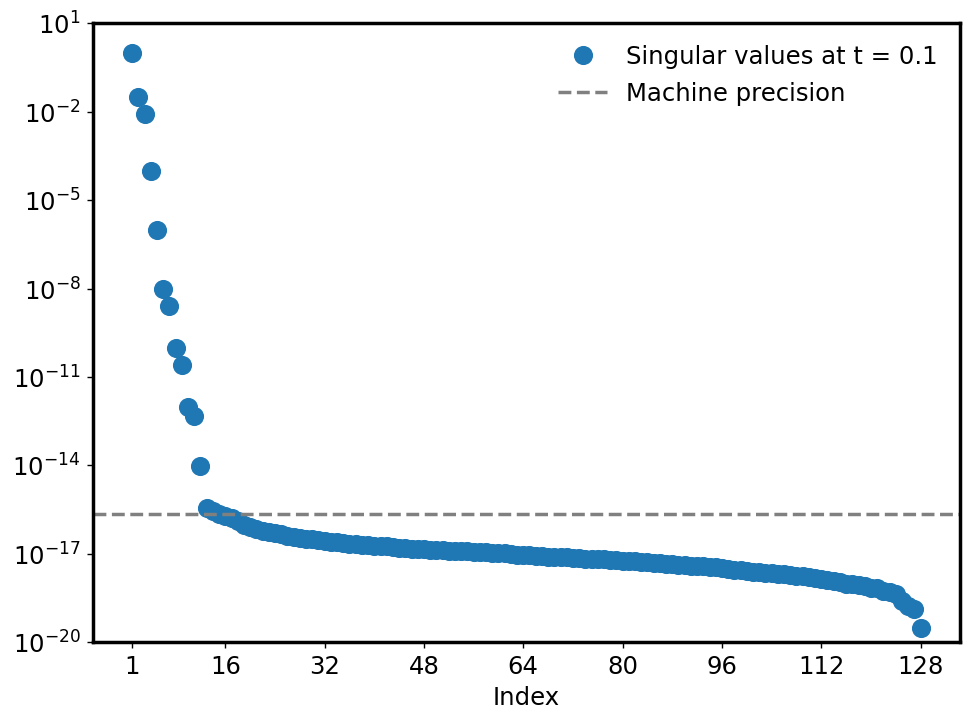

In [2]:
# Selected time steps
time_steps = [0, 30, 50, 70, 100]
labels = [f'Singular values at t = {round(ts[index], 3)}' for index in time_steps]
sing_vals = np.zeros(len(time_steps), dtype=object)

# Compute the singular values
for i, index in enumerate(time_steps):
    if isinstance(Xs_ref[index], SVD):
        Xs_ref[index] = Xs_ref[index].todense()
    sing_vals[i] = np.linalg.svd(Xs_ref[index], compute_uv=False)

# Plot the singular values at each time step
for i, _ in enumerate(time_steps):
    new_fig = plt.figure()
    indexes = np.arange(1, len(sing_vals[0])+1)
    plt.semilogy(indexes, sing_vals[i], 'o', label=labels[i])
    # Machine precision
    plt.axhline(np.finfo(float).eps, linestyle='--', color='gray', label='Machine precision')
    plt.legend()
    plt.grid()
    plt.xlabel("Index")
    plt.xticks(np.linspace(1, len(sing_vals[0]), 9, dtype=int))
    # plt.ylabel("Singular value")
    plt.tight_layout()
    plt.ylim([1e-20, 1e1])
    plt.show()

    if do_save:
        timestamp = datetime.datetime.now().strftime("%Y%m%d%H%M%S")
        new_fig.savefig(f'figures/lyapunov_singular_values_t_{time_steps[i]}_{timestamp}.pdf')


### Setup the solver and other parameters

In [3]:
# Define the methods
from scipy.sparse import linalg as spala
invA = spala.inv(ode.A).dot
dlra_solver = 'adaptive_PERK'
krylov_kwargs = {'size': 1, 'kind': 'extended', 'invA': invA, 'invB': invA}
method_kwargs = {'order': 2, 'krylov_kwargs': krylov_kwargs, 'strict_order_conditions': True}

# Define the tolerances
tolerances = [1e-5, 1e-8, 1e-11]

# Initialize the error over time matrix
nb_t_steps = len(ref_sol.Xs)
dlra_solutions = np.zeros(len(tolerances), dtype=object)

### Run the solver for different tolerances

In [4]:
# Loop over the tolerances
for j, tol in enumerate(tolerances):
    # Compute the solution with the current method
    Y0 = X0.truncate(rtol = tol)
    dlra_solutions[j] = solve_adaptive_dlra(ode, t_span, Y0, adaptive_dlra_solver=dlra_solver, solver_kwargs=method_kwargs, monitor=True, t_eval=ts, rtol=tol, atol=None)

# Compute the error over time
errors = np.zeros((nb_t_steps, len(tolerances)))
for i in range(nb_t_steps):
    for j, tol in enumerate(tolerances):
        errors[i, j] = np.linalg.norm(Xs_ref[i] - dlra_solutions[j].Xs[i].todense(), 'fro') / np.linalg.norm(Xs_ref[i], 'fro')

# Extract the rank over time
ranks = np.zeros((nb_t_steps, len(tolerances)))
for i in np.arange(0, nb_t_steps):
    for j, tol in enumerate(tolerances):
        ranks[i, j] = dlra_solutions[j].Xs[i].rank

----------------------------------------
Adaptive PERK 
-- 1 substep(s) 
-- 2 stages 
-- Strict order conditions: True 
-- extended Krylov space and 1 iteration(s) 
-- Largest matrix shape: (8*rank, 8*rank) 
-- Relative tolerance = 1e-05 
-- Absolute tolerance = None


Solving adaptive DLRA:   0%|          | 4/1000 [00:00<00:29, 33.86it/s]

Rank has changed from 6 to 7 at t = 0.001
Rank has changed from 7 to 8 at t = 0.002


Solving adaptive DLRA:   2%|▏         | 16/1000 [00:00<00:27, 35.85it/s]

Rank has changed from 8 to 9 at t = 0.009000000000000001
Rank has changed from 9 to 7 at t = 0.01
Rank has changed from 7 to 8 at t = 0.011
Rank has changed from 8 to 7 at t = 0.013000000000000001
Rank has changed from 7 to 9 at t = 0.014
Rank has changed from 9 to 8 at t = 0.016


Solving adaptive DLRA:   2%|▏         | 24/1000 [00:00<00:26, 36.57it/s]

Rank has changed from 8 to 9 at t = 0.018000000000000002
Rank has changed from 9 to 8 at t = 0.019
Rank has changed from 8 to 9 at t = 0.02
Rank has changed from 9 to 8 at t = 0.022


Solving adaptive DLRA:   3%|▎         | 32/1000 [00:00<00:26, 36.33it/s]

Rank has changed from 8 to 9 at t = 0.026000000000000002
Rank has changed from 9 to 8 at t = 0.028
Rank has changed from 8 to 9 at t = 0.029
Rank has changed from 9 to 8 at t = 0.03
Rank has changed from 8 to 9 at t = 0.031
Rank has changed from 9 to 8 at t = 0.032


Solving adaptive DLRA:   4%|▍         | 40/1000 [00:01<00:26, 36.63it/s]

Rank has changed from 8 to 9 at t = 0.034
Rank has changed from 9 to 8 at t = 0.035
Rank has changed from 8 to 7 at t = 0.036000000000000004
Rank has changed from 7 to 8 at t = 0.038
Rank has changed from 8 to 10 at t = 0.041


Solving adaptive DLRA:   5%|▍         | 48/1000 [00:01<00:26, 35.46it/s]

Rank has changed from 10 to 8 at t = 0.042
Rank has changed from 8 to 9 at t = 0.044
Rank has changed from 9 to 8 at t = 0.048
Rank has changed from 8 to 7 at t = 0.049


Solving adaptive DLRA:   6%|▌         | 56/1000 [00:01<00:26, 35.93it/s]

Rank has changed from 7 to 9 at t = 0.05
Rank has changed from 9 to 7 at t = 0.053
Rank has changed from 7 to 8 at t = 0.054
Rank has changed from 8 to 9 at t = 0.055
Rank has changed from 9 to 8 at t = 0.056


Solving adaptive DLRA:   6%|▋         | 64/1000 [00:01<00:26, 35.49it/s]

Rank has changed from 8 to 10 at t = 0.059000000000000004
Rank has changed from 10 to 9 at t = 0.06
Rank has changed from 9 to 8 at t = 0.061
Rank has changed from 8 to 9 at t = 0.063
Rank has changed from 9 to 8 at t = 0.064
Rank has changed from 8 to 9 at t = 0.065


Solving adaptive DLRA:   7%|▋         | 72/1000 [00:02<00:26, 35.05it/s]

Rank has changed from 9 to 8 at t = 0.067
Rank has changed from 8 to 9 at t = 0.068
Rank has changed from 9 to 8 at t = 0.069
Rank has changed from 8 to 10 at t = 0.07
Rank has changed from 10 to 9 at t = 0.07100000000000001
Rank has changed from 9 to 8 at t = 0.07200000000000001


Solving adaptive DLRA:   8%|▊         | 80/1000 [00:02<00:25, 36.30it/s]

Rank has changed from 8 to 9 at t = 0.075
Rank has changed from 9 to 8 at t = 0.076
Rank has changed from 8 to 9 at t = 0.077
Rank has changed from 9 to 8 at t = 0.078


Solving adaptive DLRA:   9%|▉         | 88/1000 [00:02<00:24, 37.10it/s]

Rank has changed from 8 to 9 at t = 0.083
Rank has changed from 9 to 8 at t = 0.084
Rank has changed from 8 to 9 at t = 0.085
Rank has changed from 9 to 7 at t = 0.08600000000000001
Rank has changed from 7 to 8 at t = 0.088
Rank has changed from 8 to 9 at t = 0.089


Solving adaptive DLRA:  10%|▉         | 96/1000 [00:02<00:24, 36.79it/s]

Rank has changed from 9 to 8 at t = 0.091
Rank has changed from 8 to 9 at t = 0.095
Rank has changed from 9 to 8 at t = 0.097


Solving adaptive DLRA:  10%|█         | 104/1000 [00:02<00:24, 36.53it/s]

Rank has changed from 8 to 9 at t = 0.099
Rank has changed from 9 to 8 at t = 0.1
Rank has changed from 8 to 7 at t = 0.101
Rank has changed from 7 to 9 at t = 0.10200000000000001
Rank has changed from 9 to 7 at t = 0.10400000000000001
Rank has changed from 7 to 8 at t = 0.105


Solving adaptive DLRA:  11%|█         | 112/1000 [00:03<00:23, 37.17it/s]

Rank has changed from 8 to 9 at t = 0.107
Rank has changed from 9 to 7 at t = 0.108
Rank has changed from 7 to 8 at t = 0.109
Rank has changed from 8 to 9 at t = 0.113
Rank has changed from 9 to 8 at t = 0.114


Solving adaptive DLRA:  12%|█▏        | 120/1000 [00:03<00:23, 36.97it/s]

Rank has changed from 8 to 9 at t = 0.115
Rank has changed from 9 to 8 at t = 0.117
Rank has changed from 8 to 9 at t = 0.12
Rank has changed from 9 to 7 at t = 0.121
Rank has changed from 7 to 9 at t = 0.122


Solving adaptive DLRA:  13%|█▎        | 128/1000 [00:03<00:23, 37.37it/s]

Rank has changed from 9 to 8 at t = 0.123
Rank has changed from 8 to 7 at t = 0.125
Rank has changed from 7 to 9 at t = 0.126
Rank has changed from 9 to 7 at t = 0.129


Solving adaptive DLRA:  14%|█▎        | 136/1000 [00:03<00:22, 37.72it/s]

Rank has changed from 7 to 8 at t = 0.131
Rank has changed from 8 to 10 at t = 0.132
Rank has changed from 10 to 8 at t = 0.133
Rank has changed from 8 to 9 at t = 0.136
Rank has changed from 9 to 8 at t = 0.137


Solving adaptive DLRA:  14%|█▍        | 144/1000 [00:03<00:23, 36.55it/s]

Rank has changed from 8 to 10 at t = 0.139
Rank has changed from 10 to 9 at t = 0.14
Rank has changed from 9 to 8 at t = 0.14400000000000002


Solving adaptive DLRA:  16%|█▌        | 156/1000 [00:04<00:22, 37.44it/s]

Rank has changed from 8 to 9 at t = 0.151
Rank has changed from 9 to 7 at t = 0.152
Rank has changed from 7 to 8 at t = 0.153
Rank has changed from 8 to 9 at t = 0.156
Rank has changed from 9 to 8 at t = 0.157
Rank has changed from 8 to 9 at t = 0.158


Solving adaptive DLRA:  16%|█▋        | 164/1000 [00:04<00:22, 36.74it/s]

Rank has changed from 9 to 8 at t = 0.16
Rank has changed from 8 to 9 at t = 0.161
Rank has changed from 9 to 8 at t = 0.162
Rank has changed from 8 to 9 at t = 0.166
Rank has changed from 9 to 8 at t = 0.167


Solving adaptive DLRA:  18%|█▊        | 176/1000 [00:04<00:22, 37.09it/s]

Rank has changed from 8 to 9 at t = 0.169
Rank has changed from 9 to 8 at t = 0.17
Rank has changed from 8 to 9 at t = 0.171
Rank has changed from 9 to 8 at t = 0.17200000000000001
Rank has changed from 8 to 9 at t = 0.17300000000000001
Rank has changed from 9 to 8 at t = 0.17400000000000002
Rank has changed from 8 to 9 at t = 0.17500000000000002


Solving adaptive DLRA:  18%|█▊        | 184/1000 [00:05<00:21, 37.53it/s]

Rank has changed from 9 to 8 at t = 0.178
Rank has changed from 8 to 9 at t = 0.18
Rank has changed from 9 to 7 at t = 0.181
Rank has changed from 7 to 8 at t = 0.183
Rank has changed from 8 to 9 at t = 0.184


Solving adaptive DLRA:  19%|█▉        | 192/1000 [00:05<00:22, 36.21it/s]

Rank has changed from 9 to 8 at t = 0.186
Rank has changed from 8 to 9 at t = 0.188
Rank has changed from 9 to 8 at t = 0.189
Rank has changed from 8 to 9 at t = 0.191
Rank has changed from 9 to 8 at t = 0.192


Solving adaptive DLRA:  20%|██        | 200/1000 [00:05<00:21, 36.86it/s]

Rank has changed from 8 to 9 at t = 0.195
Rank has changed from 9 to 8 at t = 0.196
Rank has changed from 8 to 7 at t = 0.197
Rank has changed from 7 to 8 at t = 0.198
Rank has changed from 8 to 9 at t = 0.2
Rank has changed from 9 to 8 at t = 0.201
Rank has changed from 8 to 10 at t = 0.202


Solving adaptive DLRA:  21%|██        | 208/1000 [00:05<00:23, 33.52it/s]

Rank has changed from 10 to 9 at t = 0.203
Rank has changed from 9 to 10 at t = 0.20700000000000002
Rank has changed from 10 to 9 at t = 0.20800000000000002
Rank has changed from 9 to 8 at t = 0.209


Solving adaptive DLRA:  21%|██        | 212/1000 [00:05<00:26, 30.27it/s]

Rank has changed from 8 to 9 at t = 0.21
Rank has changed from 9 to 8 at t = 0.213
Rank has changed from 8 to 9 at t = 0.214


Solving adaptive DLRA:  22%|██▏       | 220/1000 [00:06<00:26, 30.00it/s]

Rank has changed from 9 to 8 at t = 0.215
Rank has changed from 8 to 10 at t = 0.216
Rank has changed from 10 to 9 at t = 0.217
Rank has changed from 9 to 8 at t = 0.218
Rank has changed from 8 to 9 at t = 0.219


Solving adaptive DLRA:  23%|██▎       | 228/1000 [00:06<00:25, 30.22it/s]

Rank has changed from 9 to 8 at t = 0.223
Rank has changed from 8 to 9 at t = 0.224
Rank has changed from 9 to 10 at t = 0.225
Rank has changed from 10 to 9 at t = 0.226
Rank has changed from 9 to 8 at t = 0.227
Rank has changed from 8 to 10 at t = 0.228


Solving adaptive DLRA:  24%|██▎       | 235/1000 [00:06<00:27, 27.97it/s]

Rank has changed from 10 to 11 at t = 0.23
Rank has changed from 11 to 9 at t = 0.231
Rank has changed from 9 to 10 at t = 0.232
Rank has changed from 10 to 9 at t = 0.234
Rank has changed from 9 to 10 at t = 0.23500000000000001


Solving adaptive DLRA:  24%|██▍       | 241/1000 [00:06<00:28, 26.40it/s]

Rank has changed from 10 to 11 at t = 0.23700000000000002
Rank has changed from 11 to 10 at t = 0.23800000000000002
Rank has changed from 10 to 11 at t = 0.24
Rank has changed from 11 to 10 at t = 0.241


Solving adaptive DLRA:  25%|██▍       | 247/1000 [00:07<00:28, 26.06it/s]

Rank has changed from 10 to 11 at t = 0.243
Rank has changed from 11 to 10 at t = 0.244
Rank has changed from 10 to 11 at t = 0.245
Rank has changed from 11 to 10 at t = 0.246
Rank has changed from 10 to 11 at t = 0.247


Solving adaptive DLRA:  25%|██▌       | 253/1000 [00:07<00:29, 25.26it/s]

Rank has changed from 11 to 10 at t = 0.248
Rank has changed from 10 to 11 at t = 0.249
Rank has changed from 11 to 10 at t = 0.25
Rank has changed from 10 to 9 at t = 0.252
Rank has changed from 9 to 10 at t = 0.253


Solving adaptive DLRA:  26%|██▌       | 259/1000 [00:07<00:29, 25.14it/s]

Rank has changed from 10 to 11 at t = 0.256
Rank has changed from 11 to 10 at t = 0.257
Rank has changed from 10 to 11 at t = 0.259
Rank has changed from 11 to 9 at t = 0.26
Rank has changed from 9 to 10 at t = 0.261


Solving adaptive DLRA:  27%|██▋       | 268/1000 [00:08<00:28, 25.78it/s]

Rank has changed from 10 to 9 at t = 0.263
Rank has changed from 9 to 10 at t = 0.264
Rank has changed from 10 to 9 at t = 0.266
Rank has changed from 9 to 10 at t = 0.267


Solving adaptive DLRA:  27%|██▋       | 274/1000 [00:08<00:28, 25.11it/s]

Rank has changed from 10 to 11 at t = 0.27
Rank has changed from 11 to 12 at t = 0.271
Rank has changed from 12 to 10 at t = 0.272
Rank has changed from 10 to 8 at t = 0.273
Rank has changed from 8 to 10 at t = 0.274


Solving adaptive DLRA:  28%|██▊       | 280/1000 [00:08<00:28, 25.35it/s]

Rank has changed from 10 to 9 at t = 0.276
Rank has changed from 9 to 10 at t = 0.277
Rank has changed from 10 to 11 at t = 0.278
Rank has changed from 11 to 10 at t = 0.279


Solving adaptive DLRA:  29%|██▊       | 286/1000 [00:08<00:28, 25.07it/s]

Rank has changed from 10 to 9 at t = 0.28200000000000003
Rank has changed from 9 to 10 at t = 0.28300000000000003
Rank has changed from 10 to 11 at t = 0.28500000000000003
Rank has changed from 11 to 10 at t = 0.28600000000000003
Rank has changed from 10 to 9 at t = 0.28700000000000003


Solving adaptive DLRA:  29%|██▉       | 292/1000 [00:08<00:27, 25.38it/s]

Rank has changed from 9 to 11 at t = 0.28800000000000003
Rank has changed from 11 to 10 at t = 0.29
Rank has changed from 10 to 11 at t = 0.292
Rank has changed from 11 to 10 at t = 0.293


Solving adaptive DLRA:  30%|██▉       | 298/1000 [00:09<00:28, 24.46it/s]

Rank has changed from 10 to 11 at t = 0.294
Rank has changed from 11 to 9 at t = 0.296
Rank has changed from 9 to 10 at t = 0.297
Rank has changed from 10 to 11 at t = 0.298


Solving adaptive DLRA:  30%|███       | 304/1000 [00:09<00:27, 24.92it/s]

Rank has changed from 11 to 9 at t = 0.299
Rank has changed from 9 to 10 at t = 0.3
Rank has changed from 10 to 11 at t = 0.301
Rank has changed from 11 to 10 at t = 0.303


Solving adaptive DLRA:  31%|███       | 310/1000 [00:09<00:27, 25.30it/s]

Rank has changed from 10 to 9 at t = 0.307
Rank has changed from 9 to 10 at t = 0.308
Rank has changed from 10 to 9 at t = 0.309
Rank has changed from 9 to 10 at t = 0.31
Rank has changed from 10 to 11 at t = 0.311
Rank has changed from 11 to 10 at t = 0.312


Solving adaptive DLRA:  32%|███▏      | 316/1000 [00:09<00:26, 25.53it/s]

Rank has changed from 10 to 11 at t = 0.313
Rank has changed from 11 to 9 at t = 0.314
Rank has changed from 9 to 10 at t = 0.315
Rank has changed from 10 to 9 at t = 0.318


Solving adaptive DLRA:  32%|███▏      | 322/1000 [00:10<00:26, 25.56it/s]

Rank has changed from 9 to 10 at t = 0.319
Rank has changed from 10 to 9 at t = 0.322
Rank has changed from 9 to 11 at t = 0.323
Rank has changed from 11 to 10 at t = 0.324


Solving adaptive DLRA:  33%|███▎      | 328/1000 [00:10<00:26, 25.07it/s]

Rank has changed from 10 to 11 at t = 0.326
Rank has changed from 11 to 9 at t = 0.328
Rank has changed from 9 to 11 at t = 0.329


Solving adaptive DLRA:  33%|███▎      | 334/1000 [00:10<00:26, 25.29it/s]

Rank has changed from 11 to 10 at t = 0.331
Rank has changed from 10 to 9 at t = 0.332
Rank has changed from 9 to 11 at t = 0.333
Rank has changed from 11 to 9 at t = 0.334
Rank has changed from 9 to 10 at t = 0.335


Solving adaptive DLRA:  34%|███▍      | 343/1000 [00:10<00:25, 25.96it/s]

Rank has changed from 10 to 9 at t = 0.338
Rank has changed from 9 to 10 at t = 0.339
Rank has changed from 10 to 11 at t = 0.34
Rank has changed from 11 to 10 at t = 0.341
Rank has changed from 10 to 9 at t = 0.343


Solving adaptive DLRA:  35%|███▍      | 346/1000 [00:11<00:25, 25.55it/s]

Rank has changed from 9 to 10 at t = 0.34400000000000003
Rank has changed from 10 to 11 at t = 0.34600000000000003
Rank has changed from 11 to 10 at t = 0.34800000000000003


Solving adaptive DLRA:  36%|███▌      | 355/1000 [00:11<00:25, 25.51it/s]

Rank has changed from 10 to 11 at t = 0.35100000000000003
Rank has changed from 11 to 10 at t = 0.352
Rank has changed from 10 to 9 at t = 0.353
Rank has changed from 9 to 10 at t = 0.355
Rank has changed from 10 to 11 at t = 0.356


Solving adaptive DLRA:  36%|███▌      | 361/1000 [00:11<00:24, 25.65it/s]

Rank has changed from 11 to 9 at t = 0.357
Rank has changed from 9 to 10 at t = 0.358
Rank has changed from 10 to 8 at t = 0.359
Rank has changed from 8 to 10 at t = 0.36
Rank has changed from 10 to 9 at t = 0.361
Rank has changed from 9 to 10 at t = 0.362


Solving adaptive DLRA:  37%|███▋      | 367/1000 [00:11<00:24, 25.58it/s]

Rank has changed from 10 to 11 at t = 0.363
Rank has changed from 11 to 9 at t = 0.365
Rank has changed from 9 to 10 at t = 0.366
Rank has changed from 10 to 11 at t = 0.367
Rank has changed from 11 to 10 at t = 0.368


Solving adaptive DLRA:  38%|███▊      | 379/1000 [00:12<00:23, 26.05it/s]

Rank has changed from 10 to 11 at t = 0.375
Rank has changed from 11 to 9 at t = 0.377
Rank has changed from 9 to 11 at t = 0.379
Rank has changed from 11 to 10 at t = 0.38


Solving adaptive DLRA:  38%|███▊      | 385/1000 [00:12<00:23, 25.73it/s]

Rank has changed from 10 to 11 at t = 0.382
Rank has changed from 11 to 10 at t = 0.383
Rank has changed from 10 to 11 at t = 0.387


Solving adaptive DLRA:  39%|███▉      | 391/1000 [00:12<00:23, 25.66it/s]

Rank has changed from 11 to 10 at t = 0.388
Rank has changed from 10 to 9 at t = 0.389
Rank has changed from 9 to 10 at t = 0.39
Rank has changed from 10 to 9 at t = 0.391
Rank has changed from 9 to 10 at t = 0.392


Solving adaptive DLRA:  40%|████      | 400/1000 [00:13<00:23, 25.86it/s]

Rank has changed from 10 to 9 at t = 0.395
Rank has changed from 9 to 10 at t = 0.397
Rank has changed from 10 to 11 at t = 0.4


Solving adaptive DLRA:  41%|████      | 406/1000 [00:13<00:23, 24.95it/s]

Rank has changed from 11 to 10 at t = 0.401
Rank has changed from 10 to 11 at t = 0.403
Rank has changed from 11 to 10 at t = 0.405
Rank has changed from 10 to 11 at t = 0.406


Solving adaptive DLRA:  42%|████▏     | 415/1000 [00:13<00:23, 25.10it/s]

Rank has changed from 11 to 10 at t = 0.41200000000000003
Rank has changed from 10 to 11 at t = 0.41300000000000003
Rank has changed from 11 to 10 at t = 0.41500000000000004
Rank has changed from 10 to 11 at t = 0.41600000000000004
Rank has changed from 11 to 10 at t = 0.417


Solving adaptive DLRA:  42%|████▏     | 424/1000 [00:14<00:22, 25.70it/s]

Rank has changed from 10 to 9 at t = 0.419
Rank has changed from 9 to 10 at t = 0.42
Rank has changed from 10 to 11 at t = 0.421
Rank has changed from 11 to 12 at t = 0.423
Rank has changed from 12 to 11 at t = 0.424


Solving adaptive DLRA:  43%|████▎     | 430/1000 [00:14<00:21, 26.39it/s]

Rank has changed from 11 to 10 at t = 0.425
Rank has changed from 10 to 11 at t = 0.426
Rank has changed from 11 to 10 at t = 0.428


Solving adaptive DLRA:  44%|████▎     | 436/1000 [00:14<00:21, 26.63it/s]

Rank has changed from 10 to 11 at t = 0.433
Rank has changed from 11 to 10 at t = 0.434
Rank has changed from 10 to 11 at t = 0.437


Solving adaptive DLRA:  44%|████▍     | 445/1000 [00:14<00:21, 25.95it/s]

Rank has changed from 11 to 10 at t = 0.44
Rank has changed from 10 to 11 at t = 0.443
Rank has changed from 11 to 10 at t = 0.445


Solving adaptive DLRA:  45%|████▌     | 451/1000 [00:15<00:21, 25.89it/s]

Rank has changed from 10 to 11 at t = 0.447
Rank has changed from 11 to 10 at t = 0.449
Rank has changed from 10 to 12 at t = 0.452


Solving adaptive DLRA:  46%|████▌     | 457/1000 [00:15<00:20, 26.11it/s]

Rank has changed from 12 to 11 at t = 0.453
Rank has changed from 11 to 10 at t = 0.454


Solving adaptive DLRA:  47%|████▋     | 469/1000 [00:15<00:19, 27.02it/s]

Rank has changed from 10 to 11 at t = 0.465
Rank has changed from 11 to 10 at t = 0.466
Rank has changed from 10 to 11 at t = 0.468
Rank has changed from 11 to 10 at t = 0.46900000000000003
Rank has changed from 10 to 9 at t = 0.47000000000000003


Solving adaptive DLRA:  48%|████▊     | 475/1000 [00:16<00:19, 26.86it/s]

Rank has changed from 9 to 10 at t = 0.47100000000000003
Rank has changed from 10 to 11 at t = 0.47200000000000003
Rank has changed from 11 to 9 at t = 0.47300000000000003
Rank has changed from 9 to 11 at t = 0.47400000000000003
Rank has changed from 11 to 10 at t = 0.47500000000000003


Solving adaptive DLRA:  48%|████▊     | 484/1000 [00:16<00:18, 27.27it/s]

Rank has changed from 10 to 11 at t = 0.47900000000000004
Rank has changed from 11 to 9 at t = 0.481
Rank has changed from 9 to 10 at t = 0.482
Rank has changed from 10 to 11 at t = 0.484


Solving adaptive DLRA:  49%|████▉     | 490/1000 [00:16<00:19, 26.65it/s]

Rank has changed from 11 to 10 at t = 0.485
Rank has changed from 10 to 11 at t = 0.486
Rank has changed from 11 to 9 at t = 0.488
Rank has changed from 9 to 10 at t = 0.489
Rank has changed from 10 to 9 at t = 0.49


Solving adaptive DLRA:  50%|████▉     | 496/1000 [00:16<00:18, 26.98it/s]

Rank has changed from 9 to 11 at t = 0.491
Rank has changed from 11 to 10 at t = 0.492
Rank has changed from 10 to 11 at t = 0.493
Rank has changed from 11 to 10 at t = 0.494
Rank has changed from 10 to 11 at t = 0.496


Solving adaptive DLRA:  50%|█████     | 502/1000 [00:17<00:18, 26.52it/s]

Rank has changed from 11 to 10 at t = 0.497
Rank has changed from 10 to 11 at t = 0.498
Rank has changed from 11 to 10 at t = 0.499
Rank has changed from 10 to 11 at t = 0.5
Rank has changed from 11 to 10 at t = 0.501


Solving adaptive DLRA:  51%|█████     | 508/1000 [00:17<00:18, 26.31it/s]

Rank has changed from 10 to 11 at t = 0.503
Rank has changed from 11 to 10 at t = 0.504
Rank has changed from 10 to 11 at t = 0.505
Rank has changed from 11 to 10 at t = 0.506
Rank has changed from 10 to 11 at t = 0.507
Rank has changed from 11 to 10 at t = 0.508


Solving adaptive DLRA:  52%|█████▏    | 517/1000 [00:17<00:18, 25.98it/s]

Rank has changed from 10 to 12 at t = 0.514
Rank has changed from 12 to 9 at t = 0.515
Rank has changed from 9 to 11 at t = 0.516
Rank has changed from 11 to 10 at t = 0.517
Rank has changed from 10 to 9 at t = 0.518
Rank has changed from 9 to 10 at t = 0.519


Solving adaptive DLRA:  52%|█████▏    | 523/1000 [00:17<00:18, 26.36it/s]

Rank has changed from 10 to 11 at t = 0.52
Rank has changed from 11 to 10 at t = 0.521
Rank has changed from 10 to 11 at t = 0.522
Rank has changed from 11 to 10 at t = 0.523
Rank has changed from 10 to 11 at t = 0.524


Solving adaptive DLRA:  53%|█████▎    | 532/1000 [00:18<00:17, 26.45it/s]

Rank has changed from 11 to 10 at t = 0.527
Rank has changed from 10 to 9 at t = 0.528
Rank has changed from 9 to 11 at t = 0.529
Rank has changed from 11 to 10 at t = 0.53
Rank has changed from 10 to 9 at t = 0.532


Solving adaptive DLRA:  54%|█████▍    | 538/1000 [00:18<00:17, 26.59it/s]

Rank has changed from 9 to 10 at t = 0.533
Rank has changed from 10 to 11 at t = 0.536
Rank has changed from 11 to 10 at t = 0.537


Solving adaptive DLRA:  54%|█████▍    | 544/1000 [00:18<00:16, 27.34it/s]

Rank has changed from 10 to 8 at t = 0.54
Rank has changed from 8 to 10 at t = 0.541
Rank has changed from 10 to 11 at t = 0.542
Rank has changed from 11 to 9 at t = 0.543
Rank has changed from 9 to 10 at t = 0.544


Solving adaptive DLRA:  55%|█████▌    | 553/1000 [00:18<00:16, 27.64it/s]

Rank has changed from 10 to 11 at t = 0.549
Rank has changed from 11 to 10 at t = 0.55
Rank has changed from 10 to 11 at t = 0.554


Solving adaptive DLRA:  56%|█████▌    | 559/1000 [00:19<00:15, 27.92it/s]

Rank has changed from 11 to 10 at t = 0.556
Rank has changed from 10 to 9 at t = 0.558
Rank has changed from 9 to 11 at t = 0.559
Rank has changed from 11 to 10 at t = 0.56
Rank has changed from 10 to 9 at t = 0.561


Solving adaptive DLRA:  57%|█████▋    | 568/1000 [00:19<00:15, 28.49it/s]

Rank has changed from 9 to 10 at t = 0.5640000000000001
Rank has changed from 10 to 9 at t = 0.5650000000000001
Rank has changed from 9 to 10 at t = 0.5670000000000001
Rank has changed from 10 to 8 at t = 0.5680000000000001
Rank has changed from 8 to 9 at t = 0.5690000000000001


Solving adaptive DLRA:  57%|█████▊    | 575/1000 [00:19<00:14, 29.00it/s]

Rank has changed from 9 to 10 at t = 0.5710000000000001
Rank has changed from 10 to 9 at t = 0.5720000000000001
Rank has changed from 9 to 10 at t = 0.5760000000000001
Rank has changed from 10 to 9 at t = 0.577


Solving adaptive DLRA:  58%|█████▊    | 583/1000 [00:20<00:13, 29.85it/s]

Rank has changed from 9 to 10 at t = 0.578
Rank has changed from 10 to 9 at t = 0.579
Rank has changed from 9 to 10 at t = 0.581
Rank has changed from 10 to 9 at t = 0.582
Rank has changed from 9 to 10 at t = 0.584


Solving adaptive DLRA:  59%|█████▉    | 591/1000 [00:20<00:13, 30.15it/s]

Rank has changed from 10 to 9 at t = 0.585
Rank has changed from 9 to 8 at t = 0.591


Solving adaptive DLRA:  60%|█████▉    | 595/1000 [00:20<00:13, 30.47it/s]

Rank has changed from 8 to 10 at t = 0.592
Rank has changed from 10 to 9 at t = 0.593
Rank has changed from 9 to 8 at t = 0.595
Rank has changed from 8 to 9 at t = 0.596
Rank has changed from 9 to 8 at t = 0.597


Solving adaptive DLRA:  60%|██████    | 603/1000 [00:20<00:12, 31.26it/s]

Rank has changed from 8 to 9 at t = 0.599
Rank has changed from 9 to 10 at t = 0.602
Rank has changed from 10 to 9 at t = 0.604


Solving adaptive DLRA:  61%|██████    | 610/1000 [00:20<00:13, 28.65it/s]

Rank has changed from 9 to 11 at t = 0.605
Rank has changed from 11 to 10 at t = 0.606
Rank has changed from 10 to 9 at t = 0.609
Rank has changed from 9 to 10 at t = 0.61


Solving adaptive DLRA:  62%|██████▏   | 619/1000 [00:21<00:14, 27.01it/s]

Rank has changed from 10 to 9 at t = 0.616
Rank has changed from 9 to 10 at t = 0.617
Rank has changed from 10 to 9 at t = 0.618
Rank has changed from 9 to 10 at t = 0.619
Rank has changed from 10 to 11 at t = 0.62
Rank has changed from 11 to 10 at t = 0.621


Solving adaptive DLRA:  62%|██████▎   | 625/1000 [00:21<00:14, 25.65it/s]

Rank has changed from 10 to 9 at t = 0.622
Rank has changed from 9 to 10 at t = 0.623


Solving adaptive DLRA:  63%|██████▎   | 631/1000 [00:21<00:14, 25.09it/s]

Rank has changed from 10 to 11 at t = 0.627
Rank has changed from 11 to 10 at t = 0.628
Rank has changed from 10 to 11 at t = 0.629
Rank has changed from 11 to 10 at t = 0.63
Rank has changed from 10 to 11 at t = 0.631


Solving adaptive DLRA:  64%|██████▎   | 637/1000 [00:22<00:14, 24.94it/s]

Rank has changed from 11 to 10 at t = 0.632
Rank has changed from 10 to 9 at t = 0.633
Rank has changed from 9 to 11 at t = 0.634
Rank has changed from 11 to 10 at t = 0.637


Solving adaptive DLRA:  64%|██████▍   | 643/1000 [00:22<00:14, 25.09it/s]

Rank has changed from 10 to 9 at t = 0.64
Rank has changed from 9 to 10 at t = 0.641
Rank has changed from 10 to 11 at t = 0.645


Solving adaptive DLRA:  65%|██████▍   | 649/1000 [00:22<00:14, 24.96it/s]

Rank has changed from 11 to 12 at t = 0.646
Rank has changed from 12 to 10 at t = 0.647
Rank has changed from 10 to 12 at t = 0.649
Rank has changed from 12 to 10 at t = 0.65


Solving adaptive DLRA:  66%|██████▌   | 658/1000 [00:22<00:13, 25.47it/s]

Rank has changed from 10 to 9 at t = 0.653
Rank has changed from 9 to 10 at t = 0.654
Rank has changed from 10 to 9 at t = 0.656
Rank has changed from 9 to 10 at t = 0.657


Solving adaptive DLRA:  66%|██████▋   | 664/1000 [00:23<00:13, 25.51it/s]

Rank has changed from 10 to 9 at t = 0.66
Rank has changed from 9 to 10 at t = 0.661
Rank has changed from 10 to 9 at t = 0.662
Rank has changed from 9 to 10 at t = 0.663
Rank has changed from 10 to 11 at t = 0.664
Rank has changed from 11 to 10 at t = 0.665


Solving adaptive DLRA:  67%|██████▋   | 673/1000 [00:23<00:13, 24.93it/s]

Rank has changed from 10 to 11 at t = 0.668
Rank has changed from 11 to 10 at t = 0.669
Rank has changed from 10 to 11 at t = 0.671
Rank has changed from 11 to 9 at t = 0.672


Solving adaptive DLRA:  68%|██████▊   | 676/1000 [00:23<00:12, 25.01it/s]

Rank has changed from 9 to 11 at t = 0.674
Rank has changed from 11 to 9 at t = 0.675
Rank has changed from 9 to 11 at t = 0.676


Solving adaptive DLRA:  68%|██████▊   | 682/1000 [00:23<00:12, 25.42it/s]

Rank has changed from 11 to 10 at t = 0.679


Solving adaptive DLRA:  69%|██████▉   | 691/1000 [00:24<00:11, 25.77it/s]

Rank has changed from 10 to 11 at t = 0.686
Rank has changed from 11 to 10 at t = 0.687
Rank has changed from 10 to 9 at t = 0.6890000000000001
Rank has changed from 9 to 10 at t = 0.6910000000000001


Solving adaptive DLRA:  70%|██████▉   | 697/1000 [00:24<00:11, 25.45it/s]

Rank has changed from 10 to 9 at t = 0.6930000000000001
Rank has changed from 9 to 10 at t = 0.6960000000000001


Solving adaptive DLRA:  71%|███████   | 706/1000 [00:24<00:11, 26.13it/s]

Rank has changed from 10 to 8 at t = 0.7010000000000001
Rank has changed from 8 to 10 at t = 0.7020000000000001
Rank has changed from 10 to 11 at t = 0.7030000000000001
Rank has changed from 11 to 9 at t = 0.704
Rank has changed from 9 to 10 at t = 0.705


Solving adaptive DLRA:  71%|███████   | 712/1000 [00:24<00:11, 26.08it/s]

Rank has changed from 10 to 9 at t = 0.709
Rank has changed from 9 to 10 at t = 0.71
Rank has changed from 10 to 11 at t = 0.712
Rank has changed from 11 to 10 at t = 0.713


Solving adaptive DLRA:  72%|███████▏  | 718/1000 [00:25<00:11, 25.00it/s]

Rank has changed from 10 to 9 at t = 0.716
Rank has changed from 9 to 10 at t = 0.717
Rank has changed from 10 to 11 at t = 0.718
Rank has changed from 11 to 10 at t = 0.719


Solving adaptive DLRA:  72%|███████▏  | 724/1000 [00:25<00:10, 25.34it/s]

Rank has changed from 10 to 11 at t = 0.721
Rank has changed from 11 to 9 at t = 0.722
Rank has changed from 9 to 10 at t = 0.723


Solving adaptive DLRA:  74%|███████▎  | 736/1000 [00:25<00:10, 25.78it/s]

Rank has changed from 10 to 9 at t = 0.731
Rank has changed from 9 to 10 at t = 0.733
Rank has changed from 10 to 11 at t = 0.736


Solving adaptive DLRA:  74%|███████▍  | 739/1000 [00:26<00:10, 25.21it/s]

Rank has changed from 11 to 10 at t = 0.737
Rank has changed from 10 to 9 at t = 0.738
Rank has changed from 9 to 11 at t = 0.739
Rank has changed from 11 to 10 at t = 0.74


Solving adaptive DLRA:  75%|███████▍  | 748/1000 [00:26<00:09, 25.90it/s]

Rank has changed from 10 to 11 at t = 0.743
Rank has changed from 11 to 9 at t = 0.744
Rank has changed from 9 to 10 at t = 0.745
Rank has changed from 10 to 9 at t = 0.746
Rank has changed from 9 to 10 at t = 0.747


Solving adaptive DLRA:  75%|███████▌  | 754/1000 [00:26<00:09, 26.09it/s]

Rank has changed from 10 to 9 at t = 0.749
Rank has changed from 9 to 10 at t = 0.75
Rank has changed from 10 to 11 at t = 0.752
Rank has changed from 11 to 10 at t = 0.753


Solving adaptive DLRA:  76%|███████▌  | 760/1000 [00:26<00:09, 25.48it/s]

Rank has changed from 10 to 11 at t = 0.755
Rank has changed from 11 to 10 at t = 0.757


Solving adaptive DLRA:  77%|███████▋  | 766/1000 [00:27<00:09, 25.28it/s]

Rank has changed from 10 to 11 at t = 0.761
Rank has changed from 11 to 10 at t = 0.763


Solving adaptive DLRA:  77%|███████▋  | 772/1000 [00:27<00:09, 25.08it/s]

Rank has changed from 10 to 9 at t = 0.769
Rank has changed from 9 to 10 at t = 0.77
Rank has changed from 10 to 9 at t = 0.772
Rank has changed from 9 to 10 at t = 0.773
Rank has changed from 10 to 11 at t = 0.774


Solving adaptive DLRA:  78%|███████▊  | 781/1000 [00:27<00:08, 25.76it/s]

Rank has changed from 11 to 10 at t = 0.776
Rank has changed from 10 to 9 at t = 0.777
Rank has changed from 9 to 10 at t = 0.778
Rank has changed from 10 to 9 at t = 0.78


Solving adaptive DLRA:  79%|███████▊  | 787/1000 [00:27<00:07, 27.65it/s]

Rank has changed from 9 to 8 at t = 0.782
Rank has changed from 8 to 9 at t = 0.783
Rank has changed from 9 to 10 at t = 0.784
Rank has changed from 10 to 9 at t = 0.786
Rank has changed from 9 to 8 at t = 0.787


Solving adaptive DLRA:  80%|███████▉  | 795/1000 [00:28<00:06, 29.99it/s]

Rank has changed from 8 to 10 at t = 0.789
Rank has changed from 10 to 9 at t = 0.79
Rank has changed from 9 to 10 at t = 0.795


Solving adaptive DLRA:  80%|████████  | 802/1000 [00:28<00:06, 31.56it/s]

Rank has changed from 10 to 9 at t = 0.796
Rank has changed from 9 to 8 at t = 0.797
Rank has changed from 8 to 9 at t = 0.798
Rank has changed from 9 to 8 at t = 0.799


Solving adaptive DLRA:  81%|████████  | 810/1000 [00:28<00:05, 34.62it/s]

Rank has changed from 8 to 9 at t = 0.803
Rank has changed from 9 to 7 at t = 0.804
Rank has changed from 7 to 9 at t = 0.805
Rank has changed from 9 to 8 at t = 0.806
Rank has changed from 8 to 7 at t = 0.808
Rank has changed from 7 to 8 at t = 0.809


Solving adaptive DLRA:  82%|████████▏ | 818/1000 [00:28<00:05, 36.29it/s]

Rank has changed from 8 to 7 at t = 0.8130000000000001
Rank has changed from 7 to 9 at t = 0.8140000000000001
Rank has changed from 9 to 7 at t = 0.8150000000000001
Rank has changed from 7 to 8 at t = 0.8160000000000001
Rank has changed from 8 to 7 at t = 0.8180000000000001
Rank has changed from 7 to 9 at t = 0.8190000000000001
Rank has changed from 9 to 8 at t = 0.8200000000000001


Solving adaptive DLRA:  83%|████████▎ | 826/1000 [00:28<00:04, 35.20it/s]

Rank has changed from 8 to 9 at t = 0.8220000000000001
Rank has changed from 9 to 8 at t = 0.8230000000000001
Rank has changed from 8 to 9 at t = 0.8240000000000001
Rank has changed from 9 to 8 at t = 0.8250000000000001
Rank has changed from 8 to 7 at t = 0.8270000000000001
Rank has changed from 7 to 8 at t = 0.8280000000000001
Rank has changed from 8 to 9 at t = 0.8290000000000001


Solving adaptive DLRA:  83%|████████▎ | 834/1000 [00:29<00:04, 35.74it/s]

Rank has changed from 9 to 8 at t = 0.8300000000000001
Rank has changed from 8 to 10 at t = 0.833
Rank has changed from 10 to 8 at t = 0.834
Rank has changed from 8 to 9 at t = 0.836
Rank has changed from 9 to 7 at t = 0.837


Solving adaptive DLRA:  84%|████████▍ | 842/1000 [00:29<00:04, 36.50it/s]

Rank has changed from 7 to 8 at t = 0.838
Rank has changed from 8 to 7 at t = 0.839
Rank has changed from 7 to 8 at t = 0.84
Rank has changed from 8 to 7 at t = 0.841
Rank has changed from 7 to 8 at t = 0.842
Rank has changed from 8 to 7 at t = 0.843
Rank has changed from 7 to 9 at t = 0.844


Solving adaptive DLRA:  85%|████████▌ | 850/1000 [00:29<00:04, 36.68it/s]

Rank has changed from 9 to 8 at t = 0.846
Rank has changed from 8 to 7 at t = 0.847
Rank has changed from 7 to 8 at t = 0.848
Rank has changed from 8 to 9 at t = 0.849
Rank has changed from 9 to 8 at t = 0.85
Rank has changed from 8 to 9 at t = 0.851
Rank has changed from 9 to 8 at t = 0.853


Solving adaptive DLRA:  87%|████████▋ | 866/1000 [00:30<00:03, 37.78it/s]

Rank has changed from 8 to 9 at t = 0.861
Rank has changed from 9 to 8 at t = 0.862
Rank has changed from 8 to 7 at t = 0.863
Rank has changed from 7 to 8 at t = 0.864
Rank has changed from 8 to 9 at t = 0.866
Rank has changed from 9 to 8 at t = 0.867
Rank has changed from 8 to 7 at t = 0.868


Solving adaptive DLRA:  87%|████████▋ | 874/1000 [00:30<00:03, 36.71it/s]

Rank has changed from 7 to 9 at t = 0.869
Rank has changed from 9 to 8 at t = 0.87
Rank has changed from 8 to 9 at t = 0.871
Rank has changed from 9 to 8 at t = 0.872
Rank has changed from 8 to 10 at t = 0.874
Rank has changed from 10 to 7 at t = 0.875
Rank has changed from 7 to 8 at t = 0.876


Solving adaptive DLRA:  88%|████████▊ | 882/1000 [00:30<00:03, 35.46it/s]

Rank has changed from 8 to 7 at t = 0.877
Rank has changed from 7 to 8 at t = 0.878
Rank has changed from 8 to 9 at t = 0.881
Rank has changed from 9 to 8 at t = 0.882


Solving adaptive DLRA:  89%|████████▉ | 890/1000 [00:30<00:03, 35.69it/s]

Rank has changed from 8 to 9 at t = 0.885
Rank has changed from 9 to 8 at t = 0.889
Rank has changed from 8 to 9 at t = 0.891


Solving adaptive DLRA:  90%|████████▉ | 898/1000 [00:30<00:02, 35.19it/s]

Rank has changed from 9 to 8 at t = 0.894
Rank has changed from 8 to 9 at t = 0.895
Rank has changed from 9 to 7 at t = 0.897
Rank has changed from 7 to 9 at t = 0.898
Rank has changed from 9 to 8 at t = 0.899
Rank has changed from 8 to 9 at t = 0.9


Solving adaptive DLRA:  91%|█████████ | 906/1000 [00:31<00:02, 35.75it/s]

Rank has changed from 9 to 8 at t = 0.902
Rank has changed from 8 to 9 at t = 0.905
Rank has changed from 9 to 8 at t = 0.906


Solving adaptive DLRA:  92%|█████████▏| 915/1000 [00:31<00:02, 36.43it/s]

Rank has changed from 8 to 9 at t = 0.911
Rank has changed from 9 to 7 at t = 0.913
Rank has changed from 7 to 9 at t = 0.914
Rank has changed from 9 to 8 at t = 0.915
Rank has changed from 8 to 7 at t = 0.917
Rank has changed from 7 to 8 at t = 0.918


Solving adaptive DLRA:  93%|█████████▎| 927/1000 [00:31<00:01, 36.82it/s]

Rank has changed from 8 to 9 at t = 0.92
Rank has changed from 9 to 7 at t = 0.922
Rank has changed from 7 to 8 at t = 0.923
Rank has changed from 8 to 9 at t = 0.926
Rank has changed from 9 to 8 at t = 0.927


Solving adaptive DLRA:  94%|█████████▎| 935/1000 [00:31<00:01, 37.13it/s]

Rank has changed from 8 to 9 at t = 0.929
Rank has changed from 9 to 8 at t = 0.93
Rank has changed from 8 to 7 at t = 0.932
Rank has changed from 7 to 8 at t = 0.933


Solving adaptive DLRA:  94%|█████████▍| 943/1000 [00:32<00:01, 35.62it/s]

Rank has changed from 8 to 9 at t = 0.9380000000000001
Rank has changed from 9 to 8 at t = 0.9390000000000001
Rank has changed from 8 to 9 at t = 0.9410000000000001


Solving adaptive DLRA:  95%|█████████▌| 951/1000 [00:32<00:01, 36.91it/s]

Rank has changed from 9 to 8 at t = 0.9450000000000001
Rank has changed from 8 to 7 at t = 0.9480000000000001
Rank has changed from 7 to 8 at t = 0.9490000000000001
Rank has changed from 8 to 7 at t = 0.9500000000000001
Rank has changed from 7 to 8 at t = 0.9510000000000001
Rank has changed from 8 to 7 at t = 0.9520000000000001


Solving adaptive DLRA:  96%|█████████▌| 959/1000 [00:32<00:01, 37.39it/s]

Rank has changed from 7 to 8 at t = 0.9530000000000001
Rank has changed from 8 to 7 at t = 0.9550000000000001
Rank has changed from 7 to 9 at t = 0.9560000000000001
Rank has changed from 9 to 8 at t = 0.9570000000000001
Rank has changed from 8 to 7 at t = 0.9590000000000001


Solving adaptive DLRA:  97%|█████████▋| 969/1000 [00:32<00:00, 40.20it/s]

Rank has changed from 7 to 8 at t = 0.961
Rank has changed from 8 to 6 at t = 0.962
Rank has changed from 6 to 7 at t = 0.964
Rank has changed from 7 to 6 at t = 0.967
Rank has changed from 6 to 7 at t = 0.968


Solving adaptive DLRA:  97%|█████████▋| 974/1000 [00:32<00:00, 41.47it/s]

Rank has changed from 7 to 6 at t = 0.97
Rank has changed from 6 to 7 at t = 0.971
Rank has changed from 7 to 6 at t = 0.973
Rank has changed from 6 to 7 at t = 0.975
Rank has changed from 7 to 6 at t = 0.976
Rank has changed from 6 to 7 at t = 0.977


Solving adaptive DLRA:  98%|█████████▊| 984/1000 [00:33<00:00, 42.99it/s]

Rank has changed from 7 to 6 at t = 0.979
Rank has changed from 6 to 5 at t = 0.98
Rank has changed from 5 to 6 at t = 0.981
Rank has changed from 6 to 7 at t = 0.983
Rank has changed from 7 to 6 at t = 0.985
Rank has changed from 6 to 5 at t = 0.987
Rank has changed from 5 to 6 at t = 0.988


Solving adaptive DLRA: 100%|█████████▉| 999/1000 [00:33<00:00, 45.99it/s]

Rank has changed from 6 to 7 at t = 0.99
Rank has changed from 7 to 6 at t = 0.991
Rank has changed from 6 to 5 at t = 0.997
Rank has changed from 5 to 6 at t = 0.998


Solving adaptive DLRA: 100%|██████████| 1000/1000 [00:33<00:00, 29.81it/s]


Rank has changed from 6 to 7 at t = 1.0
----------------------------------------
Adaptive PERK 
-- 1 substep(s) 
-- 2 stages 
-- Strict order conditions: True 
-- extended Krylov space and 1 iteration(s) 
-- Largest matrix shape: (8*rank, 8*rank) 
-- Relative tolerance = 1e-08 
-- Absolute tolerance = None


Solving adaptive DLRA:   0%|          | 3/1000 [00:00<00:43, 23.06it/s]

Rank has changed from 11 to 10 at t = 0.001
Rank has changed from 10 to 11 at t = 0.002
Rank has changed from 11 to 12 at t = 0.004
Rank has changed from 12 to 11 at t = 0.005


Solving adaptive DLRA:   1%|          | 9/1000 [00:00<00:43, 22.94it/s]

Rank has changed from 11 to 10 at t = 0.009000000000000001


Solving adaptive DLRA:   1%|          | 12/1000 [00:00<00:42, 23.52it/s]

Rank has changed from 10 to 11 at t = 0.01
Rank has changed from 11 to 12 at t = 0.011
Rank has changed from 12 to 11 at t = 0.012
Rank has changed from 11 to 10 at t = 0.013000000000000001
Rank has changed from 10 to 11 at t = 0.014


Solving adaptive DLRA:   2%|▏         | 18/1000 [00:00<00:41, 23.68it/s]

Rank has changed from 11 to 12 at t = 0.015
Rank has changed from 12 to 10 at t = 0.017
Rank has changed from 10 to 11 at t = 0.018000000000000002
Rank has changed from 11 to 10 at t = 0.019


Solving adaptive DLRA:   2%|▏         | 24/1000 [00:00<00:38, 25.11it/s]

Rank has changed from 10 to 11 at t = 0.02
Rank has changed from 11 to 9 at t = 0.021
Rank has changed from 9 to 10 at t = 0.022
Rank has changed from 10 to 9 at t = 0.024
Rank has changed from 9 to 10 at t = 0.025


Solving adaptive DLRA:   3%|▎         | 30/1000 [00:01<00:37, 26.19it/s]

Rank has changed from 10 to 11 at t = 0.027
Rank has changed from 11 to 10 at t = 0.028
Rank has changed from 10 to 9 at t = 0.03
Rank has changed from 9 to 10 at t = 0.032


Solving adaptive DLRA:   4%|▎         | 36/1000 [00:01<00:35, 27.37it/s]

Rank has changed from 10 to 9 at t = 0.033
Rank has changed from 9 to 10 at t = 0.034
Rank has changed from 10 to 11 at t = 0.036000000000000004
Rank has changed from 11 to 9 at t = 0.037


Solving adaptive DLRA:   4%|▍         | 45/1000 [00:01<00:33, 28.55it/s]

Rank has changed from 9 to 10 at t = 0.04
Rank has changed from 10 to 9 at t = 0.042
Rank has changed from 9 to 10 at t = 0.043000000000000003
Rank has changed from 10 to 9 at t = 0.044
Rank has changed from 9 to 10 at t = 0.045


Solving adaptive DLRA:   5%|▌         | 53/1000 [00:01<00:31, 29.69it/s]

Rank has changed from 10 to 9 at t = 0.048
Rank has changed from 9 to 10 at t = 0.049
Rank has changed from 10 to 9 at t = 0.051000000000000004
Rank has changed from 9 to 10 at t = 0.052000000000000005
Rank has changed from 10 to 9 at t = 0.053


Solving adaptive DLRA:   6%|▌         | 60/1000 [00:02<00:31, 29.90it/s]

Rank has changed from 9 to 8 at t = 0.055
Rank has changed from 8 to 10 at t = 0.056
Rank has changed from 10 to 9 at t = 0.058


Solving adaptive DLRA:   6%|▋         | 64/1000 [00:02<00:30, 30.59it/s]

Rank has changed from 9 to 10 at t = 0.062
Rank has changed from 10 to 9 at t = 0.063
Rank has changed from 9 to 10 at t = 0.064
Rank has changed from 10 to 9 at t = 0.066
Rank has changed from 9 to 10 at t = 0.067


Solving adaptive DLRA:   7%|▋         | 72/1000 [00:02<00:30, 30.81it/s]

Rank has changed from 10 to 8 at t = 0.069
Rank has changed from 8 to 9 at t = 0.07200000000000001
Rank has changed from 9 to 10 at t = 0.073
Rank has changed from 10 to 9 at t = 0.074
Rank has changed from 9 to 10 at t = 0.075


Solving adaptive DLRA:   8%|▊         | 80/1000 [00:02<00:30, 30.48it/s]

Rank has changed from 10 to 9 at t = 0.076
Rank has changed from 9 to 10 at t = 0.077
Rank has changed from 10 to 8 at t = 0.078
Rank has changed from 8 to 10 at t = 0.079
Rank has changed from 10 to 9 at t = 0.081


Solving adaptive DLRA:   9%|▉         | 88/1000 [00:03<00:31, 29.13it/s]

Rank has changed from 9 to 10 at t = 0.083
Rank has changed from 10 to 9 at t = 0.085
Rank has changed from 9 to 10 at t = 0.08700000000000001
Rank has changed from 10 to 9 at t = 0.088


Solving adaptive DLRA:  10%|▉         | 95/1000 [00:03<00:30, 29.54it/s]

Rank has changed from 9 to 10 at t = 0.09
Rank has changed from 10 to 9 at t = 0.091
Rank has changed from 9 to 10 at t = 0.092
Rank has changed from 10 to 9 at t = 0.093
Rank has changed from 9 to 10 at t = 0.094


Solving adaptive DLRA:  10%|█         | 102/1000 [00:03<00:29, 30.00it/s]

Rank has changed from 10 to 9 at t = 0.097
Rank has changed from 9 to 10 at t = 0.1
Rank has changed from 10 to 9 at t = 0.101
Rank has changed from 9 to 11 at t = 0.10200000000000001
Rank has changed from 11 to 10 at t = 0.10300000000000001


Solving adaptive DLRA:  11%|█         | 108/1000 [00:03<00:30, 29.52it/s]

Rank has changed from 10 to 9 at t = 0.10400000000000001
Rank has changed from 9 to 10 at t = 0.105
Rank has changed from 10 to 9 at t = 0.109


Solving adaptive DLRA:  12%|█▏        | 115/1000 [00:04<00:29, 29.83it/s]

Rank has changed from 9 to 10 at t = 0.11
Rank has changed from 10 to 9 at t = 0.112
Rank has changed from 9 to 10 at t = 0.113
Rank has changed from 10 to 9 at t = 0.114
Rank has changed from 9 to 10 at t = 0.115


Solving adaptive DLRA:  12%|█▏        | 121/1000 [00:04<00:30, 29.23it/s]

Rank has changed from 10 to 9 at t = 0.116
Rank has changed from 9 to 11 at t = 0.11800000000000001
Rank has changed from 11 to 9 at t = 0.11900000000000001
Rank has changed from 9 to 10 at t = 0.12
Rank has changed from 10 to 9 at t = 0.121


Solving adaptive DLRA:  13%|█▎        | 129/1000 [00:04<00:27, 31.82it/s]

Rank has changed from 9 to 8 at t = 0.123
Rank has changed from 8 to 9 at t = 0.124
Rank has changed from 9 to 8 at t = 0.126
Rank has changed from 8 to 9 at t = 0.127
Rank has changed from 9 to 8 at t = 0.128
Rank has changed from 8 to 10 at t = 0.129


Solving adaptive DLRA:  13%|█▎        | 133/1000 [00:04<00:28, 30.45it/s]

Rank has changed from 10 to 11 at t = 0.13
Rank has changed from 11 to 10 at t = 0.131
Rank has changed from 10 to 9 at t = 0.132
Rank has changed from 9 to 8 at t = 0.133
Rank has changed from 8 to 9 at t = 0.134


Solving adaptive DLRA:  14%|█▍        | 141/1000 [00:04<00:27, 31.47it/s]

Rank has changed from 9 to 10 at t = 0.138
Rank has changed from 10 to 9 at t = 0.139
Rank has changed from 9 to 10 at t = 0.14200000000000002
Rank has changed from 10 to 9 at t = 0.14300000000000002
Rank has changed from 9 to 10 at t = 0.14400000000000002


Solving adaptive DLRA:  15%|█▌        | 153/1000 [00:05<00:26, 31.45it/s]

Rank has changed from 10 to 9 at t = 0.149
Rank has changed from 9 to 10 at t = 0.154
Rank has changed from 10 to 9 at t = 0.155


Solving adaptive DLRA:  16%|█▌        | 161/1000 [00:05<00:26, 31.86it/s]

Rank has changed from 9 to 8 at t = 0.156
Rank has changed from 8 to 10 at t = 0.157
Rank has changed from 10 to 9 at t = 0.159
Rank has changed from 9 to 8 at t = 0.16
Rank has changed from 8 to 9 at t = 0.161
Rank has changed from 9 to 10 at t = 0.162


Solving adaptive DLRA:  17%|█▋        | 169/1000 [00:05<00:26, 31.76it/s]

Rank has changed from 10 to 9 at t = 0.163
Rank has changed from 9 to 10 at t = 0.166
Rank has changed from 10 to 9 at t = 0.167
Rank has changed from 9 to 10 at t = 0.169


Solving adaptive DLRA:  17%|█▋        | 173/1000 [00:05<00:26, 31.26it/s]

Rank has changed from 10 to 8 at t = 0.171
Rank has changed from 8 to 9 at t = 0.17200000000000001
Rank has changed from 9 to 10 at t = 0.17300000000000001
Rank has changed from 10 to 11 at t = 0.17500000000000002
Rank has changed from 11 to 10 at t = 0.176
Rank has changed from 10 to 9 at t = 0.177


Solving adaptive DLRA:  18%|█▊        | 185/1000 [00:06<00:26, 30.86it/s]

Rank has changed from 9 to 11 at t = 0.179
Rank has changed from 11 to 9 at t = 0.18
Rank has changed from 9 to 8 at t = 0.182
Rank has changed from 8 to 10 at t = 0.183
Rank has changed from 10 to 9 at t = 0.184


Solving adaptive DLRA:  19%|█▉        | 193/1000 [00:06<00:27, 29.87it/s]

Rank has changed from 9 to 10 at t = 0.188
Rank has changed from 10 to 9 at t = 0.189
Rank has changed from 9 to 10 at t = 0.19
Rank has changed from 10 to 9 at t = 0.193


Solving adaptive DLRA:  20%|██        | 201/1000 [00:06<00:25, 30.97it/s]

Rank has changed from 9 to 8 at t = 0.199
Rank has changed from 8 to 10 at t = 0.2
Rank has changed from 10 to 18 at t = 0.201
Rank has changed from 18 to 20 at t = 0.202


Solving adaptive DLRA:  20%|██        | 205/1000 [00:07<00:37, 21.26it/s]

Rank has changed from 20 to 21 at t = 0.20400000000000001
Rank has changed from 21 to 22 at t = 0.20500000000000002


Solving adaptive DLRA:  21%|██        | 208/1000 [00:07<00:44, 17.79it/s]

Rank has changed from 22 to 21 at t = 0.20700000000000002
Rank has changed from 21 to 20 at t = 0.20800000000000002
Rank has changed from 20 to 21 at t = 0.209


Solving adaptive DLRA:  21%|██        | 211/1000 [00:07<00:49, 15.81it/s]

Rank has changed from 21 to 20 at t = 0.21
Rank has changed from 20 to 21 at t = 0.212


Solving adaptive DLRA:  22%|██▏       | 217/1000 [00:08<00:57, 13.65it/s]

Rank has changed from 21 to 20 at t = 0.215
Rank has changed from 20 to 21 at t = 0.217


Solving adaptive DLRA:  22%|██▏       | 219/1000 [00:08<00:59, 13.16it/s]

Rank has changed from 21 to 20 at t = 0.218


Solving adaptive DLRA:  22%|██▎       | 225/1000 [00:08<01:02, 12.42it/s]

Rank has changed from 20 to 21 at t = 0.223


Solving adaptive DLRA:  23%|██▎       | 227/1000 [00:08<01:02, 12.28it/s]

Rank has changed from 21 to 22 at t = 0.226
Rank has changed from 22 to 21 at t = 0.227


Solving adaptive DLRA:  23%|██▎       | 231/1000 [00:09<01:03, 12.02it/s]

Rank has changed from 21 to 22 at t = 0.229
Rank has changed from 22 to 21 at t = 0.23


Solving adaptive DLRA:  24%|██▎       | 235/1000 [00:09<01:03, 11.99it/s]

Rank has changed from 21 to 22 at t = 0.233
Rank has changed from 22 to 21 at t = 0.234


Solving adaptive DLRA:  24%|██▎       | 237/1000 [00:09<01:03, 12.01it/s]

Rank has changed from 21 to 22 at t = 0.23600000000000002


Solving adaptive DLRA:  24%|██▍       | 241/1000 [00:10<01:03, 11.97it/s]

Rank has changed from 22 to 23 at t = 0.23900000000000002
Rank has changed from 23 to 22 at t = 0.24


Solving adaptive DLRA:  24%|██▍       | 243/1000 [00:10<01:04, 11.69it/s]

Rank has changed from 22 to 24 at t = 0.242
Rank has changed from 24 to 23 at t = 0.243
Rank has changed from 23 to 22 at t = 0.244


Solving adaptive DLRA:  25%|██▍       | 247/1000 [00:10<01:04, 11.69it/s]

Rank has changed from 22 to 23 at t = 0.245
Rank has changed from 23 to 22 at t = 0.246


Solving adaptive DLRA:  25%|██▌       | 251/1000 [00:11<01:04, 11.70it/s]

Rank has changed from 22 to 23 at t = 0.25
Rank has changed from 23 to 22 at t = 0.251
Rank has changed from 22 to 23 at t = 0.252


Solving adaptive DLRA:  26%|██▌       | 255/1000 [00:11<01:03, 11.69it/s]

Rank has changed from 23 to 22 at t = 0.253
Rank has changed from 22 to 23 at t = 0.254


Solving adaptive DLRA:  26%|██▌       | 257/1000 [00:11<01:03, 11.72it/s]

Rank has changed from 23 to 22 at t = 0.256


Solving adaptive DLRA:  26%|██▋       | 263/1000 [00:12<01:02, 11.87it/s]

Rank has changed from 22 to 23 at t = 0.262
Rank has changed from 23 to 24 at t = 0.264


Solving adaptive DLRA:  27%|██▋       | 267/1000 [00:12<01:02, 11.67it/s]

Rank has changed from 24 to 22 at t = 0.265


Solving adaptive DLRA:  27%|██▋       | 269/1000 [00:12<01:03, 11.56it/s]

Rank has changed from 22 to 23 at t = 0.268
Rank has changed from 23 to 22 at t = 0.269


Solving adaptive DLRA:  28%|██▊       | 279/1000 [00:13<01:00, 11.98it/s]

Rank has changed from 22 to 23 at t = 0.278
Rank has changed from 23 to 21 at t = 0.279


Solving adaptive DLRA:  28%|██▊       | 285/1000 [00:13<00:59, 11.94it/s]

Rank has changed from 21 to 23 at t = 0.28300000000000003
Rank has changed from 23 to 22 at t = 0.28400000000000003


Solving adaptive DLRA:  29%|██▊       | 287/1000 [00:14<00:59, 11.89it/s]

Rank has changed from 22 to 23 at t = 0.28600000000000003
Rank has changed from 23 to 22 at t = 0.28700000000000003


Solving adaptive DLRA:  29%|██▉       | 291/1000 [00:14<01:00, 11.75it/s]

Rank has changed from 22 to 23 at t = 0.289
Rank has changed from 23 to 22 at t = 0.291


Solving adaptive DLRA:  30%|██▉       | 295/1000 [00:14<01:00, 11.75it/s]

Rank has changed from 22 to 23 at t = 0.293
Rank has changed from 23 to 22 at t = 0.294
Rank has changed from 22 to 21 at t = 0.295


Solving adaptive DLRA:  30%|██▉       | 297/1000 [00:14<00:59, 11.83it/s]

Rank has changed from 21 to 22 at t = 0.296
Rank has changed from 22 to 21 at t = 0.297


Solving adaptive DLRA:  30%|███       | 301/1000 [00:15<00:59, 11.77it/s]

Rank has changed from 21 to 22 at t = 0.299


Solving adaptive DLRA:  30%|███       | 303/1000 [00:15<00:59, 11.70it/s]

Rank has changed from 22 to 21 at t = 0.302


Solving adaptive DLRA:  31%|███       | 307/1000 [00:15<00:59, 11.70it/s]

Rank has changed from 21 to 22 at t = 0.305
Rank has changed from 22 to 23 at t = 0.307


Solving adaptive DLRA:  31%|███       | 309/1000 [00:15<00:59, 11.71it/s]

Rank has changed from 23 to 22 at t = 0.308
Rank has changed from 22 to 23 at t = 0.309
Rank has changed from 23 to 22 at t = 0.31


Solving adaptive DLRA:  31%|███▏      | 313/1000 [00:16<00:58, 11.73it/s]

Rank has changed from 22 to 23 at t = 0.312
Rank has changed from 23 to 22 at t = 0.314


Solving adaptive DLRA:  32%|███▏      | 319/1000 [00:16<00:58, 11.70it/s]

Rank has changed from 22 to 23 at t = 0.318
Rank has changed from 23 to 22 at t = 0.319


Solving adaptive DLRA:  32%|███▏      | 323/1000 [00:17<00:57, 11.72it/s]

Rank has changed from 22 to 23 at t = 0.321
Rank has changed from 23 to 22 at t = 0.322
Rank has changed from 22 to 23 at t = 0.323


Solving adaptive DLRA:  32%|███▎      | 325/1000 [00:17<00:58, 11.64it/s]

Rank has changed from 23 to 22 at t = 0.324


Solving adaptive DLRA:  33%|███▎      | 329/1000 [00:17<00:57, 11.66it/s]

Rank has changed from 22 to 23 at t = 0.328
Rank has changed from 23 to 22 at t = 0.329
Rank has changed from 22 to 21 at t = 0.33


Solving adaptive DLRA:  33%|███▎      | 333/1000 [00:18<00:56, 11.71it/s]

Rank has changed from 21 to 22 at t = 0.331


Solving adaptive DLRA:  34%|███▎      | 335/1000 [00:18<00:56, 11.68it/s]

Rank has changed from 22 to 23 at t = 0.334
Rank has changed from 23 to 22 at t = 0.335


Solving adaptive DLRA:  34%|███▍      | 339/1000 [00:18<00:57, 11.47it/s]

Rank has changed from 22 to 24 at t = 0.337
Rank has changed from 24 to 22 at t = 0.338


Solving adaptive DLRA:  34%|███▍      | 341/1000 [00:18<00:57, 11.53it/s]

Rank has changed from 22 to 23 at t = 0.34
Rank has changed from 23 to 22 at t = 0.341
Rank has changed from 22 to 23 at t = 0.342


Solving adaptive DLRA:  34%|███▍      | 345/1000 [00:19<00:56, 11.54it/s]

Rank has changed from 23 to 22 at t = 0.34400000000000003


Solving adaptive DLRA:  35%|███▍      | 349/1000 [00:19<00:55, 11.65it/s]

Rank has changed from 22 to 23 at t = 0.34800000000000003
Rank has changed from 23 to 22 at t = 0.34900000000000003


Solving adaptive DLRA:  35%|███▌      | 353/1000 [00:19<00:55, 11.68it/s]

Rank has changed from 22 to 24 at t = 0.35100000000000003
Rank has changed from 24 to 22 at t = 0.352


Solving adaptive DLRA:  36%|███▌      | 355/1000 [00:19<00:55, 11.66it/s]

Rank has changed from 22 to 23 at t = 0.354
Rank has changed from 23 to 22 at t = 0.355


Solving adaptive DLRA:  36%|███▌      | 359/1000 [00:20<00:54, 11.75it/s]

Rank has changed from 22 to 23 at t = 0.357
Rank has changed from 23 to 22 at t = 0.358
Rank has changed from 22 to 21 at t = 0.359


Solving adaptive DLRA:  36%|███▌      | 361/1000 [00:20<00:55, 11.45it/s]

Rank has changed from 21 to 23 at t = 0.36
Rank has changed from 23 to 21 at t = 0.361


Solving adaptive DLRA:  36%|███▋      | 365/1000 [00:20<00:54, 11.56it/s]

Rank has changed from 21 to 22 at t = 0.363
Rank has changed from 22 to 21 at t = 0.364


Solving adaptive DLRA:  37%|███▋      | 367/1000 [00:20<00:54, 11.57it/s]

Rank has changed from 21 to 23 at t = 0.366
Rank has changed from 23 to 21 at t = 0.367


Solving adaptive DLRA:  37%|███▋      | 371/1000 [00:21<00:54, 11.63it/s]

Rank has changed from 21 to 22 at t = 0.369


Solving adaptive DLRA:  38%|███▊      | 377/1000 [00:21<00:52, 11.79it/s]

Rank has changed from 22 to 23 at t = 0.376
Rank has changed from 23 to 22 at t = 0.377


Solving adaptive DLRA:  38%|███▊      | 381/1000 [00:22<00:52, 11.78it/s]

Rank has changed from 22 to 23 at t = 0.379
Rank has changed from 23 to 22 at t = 0.38


Solving adaptive DLRA:  38%|███▊      | 383/1000 [00:22<00:53, 11.63it/s]

Rank has changed from 22 to 23 at t = 0.382
Rank has changed from 23 to 22 at t = 0.383
Rank has changed from 22 to 23 at t = 0.384


Solving adaptive DLRA:  39%|███▊      | 387/1000 [00:22<00:52, 11.69it/s]

Rank has changed from 23 to 22 at t = 0.385


Solving adaptive DLRA:  39%|███▉      | 389/1000 [00:22<00:51, 11.77it/s]

Rank has changed from 22 to 21 at t = 0.388
Rank has changed from 21 to 22 at t = 0.389


Solving adaptive DLRA:  39%|███▉      | 393/1000 [00:23<00:52, 11.53it/s]

Rank has changed from 22 to 23 at t = 0.391
Rank has changed from 23 to 22 at t = 0.392


Solving adaptive DLRA:  40%|███▉      | 397/1000 [00:23<00:51, 11.63it/s]

Rank has changed from 22 to 23 at t = 0.395
Rank has changed from 23 to 22 at t = 0.396
Rank has changed from 22 to 23 at t = 0.397


Solving adaptive DLRA:  40%|████      | 401/1000 [00:23<00:51, 11.72it/s]

Rank has changed from 23 to 22 at t = 0.399
Rank has changed from 22 to 17 at t = 0.401


Solving adaptive DLRA:  40%|████      | 403/1000 [00:24<00:49, 12.00it/s]

Rank has changed from 17 to 15 at t = 0.402
Rank has changed from 15 to 16 at t = 0.403
Rank has changed from 16 to 15 at t = 0.404


Solving adaptive DLRA:  41%|████      | 409/1000 [00:24<00:41, 14.18it/s]

Rank has changed from 15 to 14 at t = 0.40700000000000003
Rank has changed from 14 to 15 at t = 0.40800000000000003
Rank has changed from 15 to 14 at t = 0.40900000000000003
Rank has changed from 14 to 15 at t = 0.41000000000000003


Solving adaptive DLRA:  41%|████▏     | 413/1000 [00:24<00:38, 15.15it/s]

Rank has changed from 15 to 14 at t = 0.41100000000000003
Rank has changed from 14 to 13 at t = 0.41300000000000003
Rank has changed from 13 to 14 at t = 0.41400000000000003


Solving adaptive DLRA:  42%|████▏     | 419/1000 [00:24<00:35, 16.41it/s]

Rank has changed from 14 to 13 at t = 0.417
Rank has changed from 13 to 15 at t = 0.419
Rank has changed from 15 to 13 at t = 0.42


Solving adaptive DLRA:  42%|████▏     | 423/1000 [00:25<00:35, 16.45it/s]

Rank has changed from 13 to 14 at t = 0.421
Rank has changed from 14 to 13 at t = 0.422
Rank has changed from 13 to 14 at t = 0.423
Rank has changed from 14 to 12 at t = 0.424


Solving adaptive DLRA:  43%|████▎     | 427/1000 [00:25<00:34, 16.62it/s]

Rank has changed from 12 to 13 at t = 0.425


Solving adaptive DLRA:  43%|████▎     | 431/1000 [00:25<00:36, 15.69it/s]

Rank has changed from 13 to 14 at t = 0.429
Rank has changed from 14 to 13 at t = 0.43


Solving adaptive DLRA:  44%|████▎     | 435/1000 [00:25<00:35, 16.10it/s]

Rank has changed from 13 to 14 at t = 0.432
Rank has changed from 14 to 13 at t = 0.434


Solving adaptive DLRA:  44%|████▍     | 439/1000 [00:26<00:34, 16.03it/s]

Rank has changed from 13 to 15 at t = 0.437
Rank has changed from 15 to 14 at t = 0.438
Rank has changed from 14 to 13 at t = 0.439


Solving adaptive DLRA:  44%|████▍     | 443/1000 [00:26<00:36, 15.42it/s]

Rank has changed from 13 to 14 at t = 0.441
Rank has changed from 14 to 15 at t = 0.442
Rank has changed from 15 to 13 at t = 0.443


Solving adaptive DLRA:  45%|████▍     | 447/1000 [00:26<00:35, 15.71it/s]

Rank has changed from 13 to 14 at t = 0.444
Rank has changed from 14 to 13 at t = 0.445
Rank has changed from 13 to 14 at t = 0.447


Solving adaptive DLRA:  45%|████▌     | 451/1000 [00:27<00:35, 15.50it/s]

Rank has changed from 14 to 15 at t = 0.448
Rank has changed from 15 to 13 at t = 0.449
Rank has changed from 13 to 12 at t = 0.451


Solving adaptive DLRA:  46%|████▌     | 455/1000 [00:27<00:33, 16.35it/s]

Rank has changed from 12 to 13 at t = 0.453
Rank has changed from 13 to 11 at t = 0.455
Rank has changed from 11 to 12 at t = 0.456


Solving adaptive DLRA:  46%|████▌     | 459/1000 [00:27<00:31, 16.93it/s]

Rank has changed from 12 to 13 at t = 0.457
Rank has changed from 13 to 12 at t = 0.458
Rank has changed from 12 to 13 at t = 0.459


Solving adaptive DLRA:  46%|████▋     | 463/1000 [00:27<00:31, 16.99it/s]

Rank has changed from 13 to 12 at t = 0.461
Rank has changed from 12 to 13 at t = 0.462
Rank has changed from 13 to 14 at t = 0.463
Rank has changed from 14 to 13 at t = 0.464


Solving adaptive DLRA:  47%|████▋     | 467/1000 [00:27<00:31, 17.16it/s]

Rank has changed from 13 to 12 at t = 0.465
Rank has changed from 12 to 14 at t = 0.467
Rank has changed from 14 to 12 at t = 0.468


Solving adaptive DLRA:  47%|████▋     | 471/1000 [00:28<00:30, 17.26it/s]

Rank has changed from 12 to 13 at t = 0.46900000000000003
Rank has changed from 13 to 14 at t = 0.47100000000000003
Rank has changed from 14 to 12 at t = 0.47200000000000003


Solving adaptive DLRA:  48%|████▊     | 475/1000 [00:28<00:32, 16.16it/s]

Rank has changed from 12 to 13 at t = 0.47300000000000003
Rank has changed from 13 to 12 at t = 0.47400000000000003
Rank has changed from 12 to 13 at t = 0.47500000000000003


Solving adaptive DLRA:  48%|████▊     | 479/1000 [00:28<00:30, 16.86it/s]

Rank has changed from 13 to 12 at t = 0.47700000000000004
Rank has changed from 12 to 13 at t = 0.47800000000000004
Rank has changed from 13 to 14 at t = 0.47900000000000004


Solving adaptive DLRA:  48%|████▊     | 483/1000 [00:28<00:30, 17.08it/s]

Rank has changed from 14 to 13 at t = 0.481
Rank has changed from 13 to 12 at t = 0.483
Rank has changed from 12 to 14 at t = 0.484


Solving adaptive DLRA:  49%|████▊     | 487/1000 [00:29<00:29, 17.11it/s]

Rank has changed from 14 to 12 at t = 0.485
Rank has changed from 12 to 14 at t = 0.486
Rank has changed from 14 to 11 at t = 0.487
Rank has changed from 11 to 12 at t = 0.488


Solving adaptive DLRA:  49%|████▉     | 491/1000 [00:29<00:29, 17.37it/s]

Rank has changed from 12 to 13 at t = 0.489
Rank has changed from 13 to 12 at t = 0.49
Rank has changed from 12 to 13 at t = 0.491


Solving adaptive DLRA:  50%|████▉     | 495/1000 [00:29<00:29, 17.22it/s]

Rank has changed from 13 to 14 at t = 0.493
Rank has changed from 14 to 13 at t = 0.494
Rank has changed from 13 to 12 at t = 0.495


Solving adaptive DLRA:  50%|████▉     | 499/1000 [00:29<00:29, 17.25it/s]

Rank has changed from 12 to 13 at t = 0.497
Rank has changed from 13 to 12 at t = 0.498
Rank has changed from 12 to 13 at t = 0.499
Rank has changed from 13 to 12 at t = 0.5


Solving adaptive DLRA:  50%|█████     | 503/1000 [00:30<00:28, 17.26it/s]

Rank has changed from 12 to 13 at t = 0.501
Rank has changed from 13 to 12 at t = 0.504


Solving adaptive DLRA:  51%|█████     | 507/1000 [00:30<00:28, 17.32it/s]

Rank has changed from 12 to 13 at t = 0.505
Rank has changed from 13 to 12 at t = 0.507


Solving adaptive DLRA:  51%|█████     | 511/1000 [00:30<00:28, 16.92it/s]

Rank has changed from 12 to 13 at t = 0.509
Rank has changed from 13 to 12 at t = 0.51
Rank has changed from 12 to 13 at t = 0.511
Rank has changed from 13 to 14 at t = 0.512


Solving adaptive DLRA:  52%|█████▏    | 515/1000 [00:30<00:28, 16.95it/s]

Rank has changed from 14 to 13 at t = 0.513
Rank has changed from 13 to 14 at t = 0.515
Rank has changed from 14 to 12 at t = 0.516


Solving adaptive DLRA:  52%|█████▏    | 519/1000 [00:30<00:28, 17.08it/s]

Rank has changed from 12 to 13 at t = 0.517


Solving adaptive DLRA:  52%|█████▎    | 525/1000 [00:31<00:28, 16.58it/s]

Rank has changed from 13 to 14 at t = 0.522
Rank has changed from 14 to 13 at t = 0.523
Rank has changed from 13 to 12 at t = 0.525


Solving adaptive DLRA:  53%|█████▎    | 529/1000 [00:31<00:27, 17.40it/s]

Rank has changed from 12 to 13 at t = 0.526
Rank has changed from 13 to 12 at t = 0.527


Solving adaptive DLRA:  53%|█████▎    | 533/1000 [00:31<00:29, 15.70it/s]

Rank has changed from 12 to 14 at t = 0.532
Rank has changed from 14 to 13 at t = 0.533


Solving adaptive DLRA:  54%|█████▎    | 537/1000 [00:32<00:29, 15.67it/s]

Rank has changed from 13 to 12 at t = 0.535
Rank has changed from 12 to 13 at t = 0.536
Rank has changed from 13 to 12 at t = 0.538


Solving adaptive DLRA:  54%|█████▍    | 541/1000 [00:32<00:26, 17.02it/s]

Rank has changed from 12 to 13 at t = 0.539
Rank has changed from 13 to 14 at t = 0.541
Rank has changed from 14 to 13 at t = 0.542


Solving adaptive DLRA:  55%|█████▍    | 545/1000 [00:32<00:29, 15.56it/s]

Rank has changed from 13 to 14 at t = 0.544
Rank has changed from 14 to 13 at t = 0.545
Rank has changed from 13 to 12 at t = 0.546


Solving adaptive DLRA:  55%|█████▌    | 551/1000 [00:32<00:26, 16.94it/s]

Rank has changed from 12 to 14 at t = 0.548
Rank has changed from 14 to 13 at t = 0.549


Solving adaptive DLRA:  56%|█████▌    | 555/1000 [00:33<00:26, 16.87it/s]

Rank has changed from 13 to 14 at t = 0.552
Rank has changed from 14 to 12 at t = 0.553
Rank has changed from 12 to 13 at t = 0.554
Rank has changed from 13 to 14 at t = 0.555


Solving adaptive DLRA:  56%|█████▌    | 559/1000 [00:33<00:26, 16.70it/s]

Rank has changed from 14 to 12 at t = 0.556
Rank has changed from 12 to 13 at t = 0.557
Rank has changed from 13 to 12 at t = 0.558
Rank has changed from 12 to 14 at t = 0.559


Solving adaptive DLRA:  56%|█████▋    | 563/1000 [00:33<00:25, 17.26it/s]

Rank has changed from 14 to 13 at t = 0.561


Solving adaptive DLRA:  57%|█████▋    | 571/1000 [00:34<00:24, 17.76it/s]

Rank has changed from 13 to 12 at t = 0.5680000000000001
Rank has changed from 12 to 14 at t = 0.5690000000000001
Rank has changed from 14 to 12 at t = 0.5700000000000001
Rank has changed from 12 to 13 at t = 0.5710000000000001


Solving adaptive DLRA:  58%|█████▊    | 577/1000 [00:34<00:23, 17.87it/s]

Rank has changed from 13 to 14 at t = 0.5750000000000001
Rank has changed from 14 to 13 at t = 0.5760000000000001
Rank has changed from 13 to 12 at t = 0.577
Rank has changed from 12 to 13 at t = 0.578


Solving adaptive DLRA:  58%|█████▊    | 581/1000 [00:34<00:23, 17.70it/s]

Rank has changed from 13 to 12 at t = 0.579
Rank has changed from 12 to 13 at t = 0.58


Solving adaptive DLRA:  59%|█████▉    | 591/1000 [00:35<00:22, 18.12it/s]

Rank has changed from 13 to 12 at t = 0.589
Rank has changed from 12 to 13 at t = 0.59
Rank has changed from 13 to 12 at t = 0.591
Rank has changed from 12 to 13 at t = 0.592


Solving adaptive DLRA:  60%|█████▉    | 599/1000 [00:35<00:21, 18.82it/s]

Rank has changed from 13 to 12 at t = 0.596
Rank has changed from 12 to 13 at t = 0.597


Solving adaptive DLRA:  60%|██████    | 601/1000 [00:35<00:21, 18.42it/s]

Rank has changed from 13 to 14 at t = 0.6
Rank has changed from 14 to 19 at t = 0.601
Rank has changed from 19 to 20 at t = 0.602


Solving adaptive DLRA:  60%|██████    | 605/1000 [00:36<00:27, 14.36it/s]

Rank has changed from 20 to 21 at t = 0.603
Rank has changed from 21 to 20 at t = 0.604
Rank has changed from 20 to 22 at t = 0.605


Solving adaptive DLRA:  61%|██████    | 607/1000 [00:36<00:28, 13.57it/s]

Rank has changed from 22 to 21 at t = 0.606


Solving adaptive DLRA:  61%|██████    | 611/1000 [00:36<00:30, 12.75it/s]

Rank has changed from 21 to 22 at t = 0.609


Solving adaptive DLRA:  61%|██████▏   | 613/1000 [00:36<00:30, 12.49it/s]

Rank has changed from 22 to 21 at t = 0.612
Rank has changed from 21 to 22 at t = 0.613
Rank has changed from 22 to 21 at t = 0.614


Solving adaptive DLRA:  62%|██████▏   | 617/1000 [00:37<00:31, 12.26it/s]

Rank has changed from 21 to 22 at t = 0.615


Solving adaptive DLRA:  62%|██████▎   | 625/1000 [00:37<00:30, 12.20it/s]

Rank has changed from 22 to 21 at t = 0.624
Rank has changed from 21 to 20 at t = 0.626


Solving adaptive DLRA:  63%|██████▎   | 629/1000 [00:38<00:30, 12.12it/s]

Rank has changed from 20 to 21 at t = 0.627
Rank has changed from 21 to 22 at t = 0.628
Rank has changed from 22 to 21 at t = 0.629


Solving adaptive DLRA:  63%|██████▎   | 631/1000 [00:38<00:30, 11.95it/s]

Rank has changed from 21 to 22 at t = 0.63


Solving adaptive DLRA:  64%|██████▎   | 637/1000 [00:38<00:30, 12.06it/s]

Rank has changed from 22 to 21 at t = 0.635
Rank has changed from 21 to 23 at t = 0.636
Rank has changed from 23 to 21 at t = 0.637


Solving adaptive DLRA:  64%|██████▍   | 641/1000 [00:39<00:29, 12.01it/s]

Rank has changed from 21 to 23 at t = 0.639
Rank has changed from 23 to 22 at t = 0.64


Solving adaptive DLRA:  64%|██████▍   | 645/1000 [00:39<00:29, 12.03it/s]

Rank has changed from 22 to 21 at t = 0.644
Rank has changed from 21 to 22 at t = 0.645


Solving adaptive DLRA:  65%|██████▍   | 649/1000 [00:39<00:29, 12.03it/s]

Rank has changed from 22 to 21 at t = 0.648


Solving adaptive DLRA:  65%|██████▌   | 653/1000 [00:40<00:29, 11.93it/s]

Rank has changed from 21 to 22 at t = 0.651
Rank has changed from 22 to 21 at t = 0.652
Rank has changed from 21 to 22 at t = 0.653


Solving adaptive DLRA:  66%|██████▌   | 657/1000 [00:40<00:28, 11.97it/s]

Rank has changed from 22 to 21 at t = 0.656
Rank has changed from 21 to 22 at t = 0.657
Rank has changed from 22 to 21 at t = 0.658


Solving adaptive DLRA:  66%|██████▌   | 661/1000 [00:40<00:28, 11.82it/s]

Rank has changed from 21 to 22 at t = 0.66
Rank has changed from 22 to 21 at t = 0.661
Rank has changed from 21 to 22 at t = 0.662


Solving adaptive DLRA:  66%|██████▋   | 665/1000 [00:41<00:29, 11.52it/s]

Rank has changed from 22 to 21 at t = 0.663
Rank has changed from 21 to 22 at t = 0.665


Solving adaptive DLRA:  67%|██████▋   | 669/1000 [00:41<00:29, 11.41it/s]

Rank has changed from 22 to 21 at t = 0.668
Rank has changed from 21 to 22 at t = 0.67


Solving adaptive DLRA:  67%|██████▋   | 673/1000 [00:41<00:28, 11.31it/s]

Rank has changed from 22 to 21 at t = 0.671
Rank has changed from 21 to 22 at t = 0.672
Rank has changed from 22 to 23 at t = 0.673


Solving adaptive DLRA:  68%|██████▊   | 675/1000 [00:41<00:28, 11.46it/s]

Rank has changed from 23 to 21 at t = 0.674
Rank has changed from 21 to 22 at t = 0.676


Solving adaptive DLRA:  68%|██████▊   | 679/1000 [00:42<00:27, 11.69it/s]

Rank has changed from 22 to 21 at t = 0.677
Rank has changed from 21 to 23 at t = 0.678
Rank has changed from 23 to 21 at t = 0.679


Solving adaptive DLRA:  68%|██████▊   | 681/1000 [00:42<00:27, 11.70it/s]

Rank has changed from 21 to 22 at t = 0.68
Rank has changed from 22 to 21 at t = 0.681
Rank has changed from 21 to 22 at t = 0.682


Solving adaptive DLRA:  68%|██████▊   | 685/1000 [00:42<00:26, 11.94it/s]

Rank has changed from 22 to 21 at t = 0.684
Rank has changed from 21 to 22 at t = 0.686


Solving adaptive DLRA:  69%|██████▉   | 689/1000 [00:43<00:26, 11.75it/s]

Rank has changed from 22 to 21 at t = 0.6880000000000001
Rank has changed from 21 to 22 at t = 0.6890000000000001


Solving adaptive DLRA:  70%|██████▉   | 695/1000 [00:43<00:25, 11.93it/s]

Rank has changed from 22 to 21 at t = 0.6930000000000001
Rank has changed from 21 to 22 at t = 0.6940000000000001


Solving adaptive DLRA:  70%|███████   | 701/1000 [00:44<00:24, 12.02it/s]

Rank has changed from 22 to 21 at t = 0.7000000000000001
Rank has changed from 21 to 22 at t = 0.7010000000000001


Solving adaptive DLRA:  70%|███████   | 705/1000 [00:44<00:24, 12.06it/s]

Rank has changed from 22 to 23 at t = 0.704
Rank has changed from 23 to 22 at t = 0.706


Solving adaptive DLRA:  71%|███████   | 711/1000 [00:44<00:23, 12.11it/s]

Rank has changed from 22 to 23 at t = 0.71
Rank has changed from 23 to 22 at t = 0.711
Rank has changed from 22 to 23 at t = 0.712


Solving adaptive DLRA:  72%|███████▏  | 715/1000 [00:45<00:23, 12.06it/s]

Rank has changed from 23 to 22 at t = 0.713
Rank has changed from 22 to 23 at t = 0.715


Solving adaptive DLRA:  72%|███████▏  | 717/1000 [00:45<00:23, 11.91it/s]

Rank has changed from 23 to 22 at t = 0.716
Rank has changed from 22 to 23 at t = 0.718


Solving adaptive DLRA:  72%|███████▏  | 721/1000 [00:45<00:23, 11.95it/s]

Rank has changed from 23 to 22 at t = 0.719
Rank has changed from 22 to 23 at t = 0.721


Solving adaptive DLRA:  72%|███████▏  | 723/1000 [00:45<00:23, 11.95it/s]

Rank has changed from 23 to 22 at t = 0.722
Rank has changed from 22 to 23 at t = 0.723


Solving adaptive DLRA:  73%|███████▎  | 727/1000 [00:46<00:22, 11.97it/s]

Rank has changed from 23 to 22 at t = 0.725
Rank has changed from 22 to 23 at t = 0.726
Rank has changed from 23 to 22 at t = 0.727


Solving adaptive DLRA:  73%|███████▎  | 729/1000 [00:46<00:22, 12.01it/s]

Rank has changed from 22 to 23 at t = 0.728
Rank has changed from 23 to 22 at t = 0.729


Solving adaptive DLRA:  73%|███████▎  | 733/1000 [00:46<00:22, 12.12it/s]

Rank has changed from 22 to 21 at t = 0.732
Rank has changed from 21 to 22 at t = 0.733


Solving adaptive DLRA:  74%|███████▎  | 737/1000 [00:47<00:21, 12.11it/s]

Rank has changed from 22 to 21 at t = 0.735
Rank has changed from 21 to 22 at t = 0.737


Solving adaptive DLRA:  74%|███████▍  | 739/1000 [00:47<00:21, 11.93it/s]

Rank has changed from 22 to 21 at t = 0.738
Rank has changed from 21 to 22 at t = 0.739
Rank has changed from 22 to 21 at t = 0.74


Solving adaptive DLRA:  74%|███████▍  | 745/1000 [00:47<00:21, 12.07it/s]

Rank has changed from 21 to 22 at t = 0.744
Rank has changed from 22 to 21 at t = 0.746


Solving adaptive DLRA:  75%|███████▍  | 749/1000 [00:48<00:20, 12.04it/s]

Rank has changed from 21 to 22 at t = 0.747
Rank has changed from 22 to 21 at t = 0.748


Solving adaptive DLRA:  75%|███████▌  | 753/1000 [00:48<00:20, 12.10it/s]

Rank has changed from 21 to 22 at t = 0.751
Rank has changed from 22 to 21 at t = 0.752


Solving adaptive DLRA:  76%|███████▌  | 755/1000 [00:48<00:20, 12.05it/s]

Rank has changed from 21 to 22 at t = 0.754
Rank has changed from 22 to 23 at t = 0.756


Solving adaptive DLRA:  76%|███████▌  | 759/1000 [00:48<00:19, 12.10it/s]

Rank has changed from 23 to 22 at t = 0.757
Rank has changed from 22 to 23 at t = 0.758


Solving adaptive DLRA:  76%|███████▌  | 761/1000 [00:49<00:19, 12.01it/s]

Rank has changed from 23 to 22 at t = 0.76
Rank has changed from 22 to 24 at t = 0.762


Solving adaptive DLRA:  76%|███████▋  | 765/1000 [00:49<00:19, 11.92it/s]

Rank has changed from 24 to 22 at t = 0.763
Rank has changed from 22 to 24 at t = 0.765


Solving adaptive DLRA:  77%|███████▋  | 767/1000 [00:49<00:19, 11.90it/s]

Rank has changed from 24 to 22 at t = 0.766
Rank has changed from 22 to 23 at t = 0.767
Rank has changed from 23 to 22 at t = 0.768


Solving adaptive DLRA:  77%|███████▋  | 773/1000 [00:50<00:18, 12.14it/s]

Rank has changed from 22 to 21 at t = 0.772
Rank has changed from 21 to 22 at t = 0.773
Rank has changed from 22 to 23 at t = 0.774


Solving adaptive DLRA:  78%|███████▊  | 777/1000 [00:50<00:18, 12.11it/s]

Rank has changed from 23 to 22 at t = 0.775
Rank has changed from 22 to 21 at t = 0.776


Solving adaptive DLRA:  78%|███████▊  | 781/1000 [00:50<00:18, 12.16it/s]

Rank has changed from 21 to 20 at t = 0.78
Rank has changed from 20 to 21 at t = 0.782


Solving adaptive DLRA:  78%|███████▊  | 785/1000 [00:51<00:17, 12.23it/s]

Rank has changed from 21 to 20 at t = 0.784
Rank has changed from 20 to 22 at t = 0.786


Solving adaptive DLRA:  79%|███████▉  | 789/1000 [00:51<00:17, 12.22it/s]

Rank has changed from 22 to 21 at t = 0.787


Solving adaptive DLRA:  80%|███████▉  | 795/1000 [00:51<00:16, 12.06it/s]

Rank has changed from 21 to 20 at t = 0.793
Rank has changed from 20 to 21 at t = 0.794


Solving adaptive DLRA:  80%|███████▉  | 797/1000 [00:52<00:16, 12.10it/s]

Rank has changed from 21 to 22 at t = 0.796
Rank has changed from 22 to 21 at t = 0.797
Rank has changed from 21 to 20 at t = 0.798


Solving adaptive DLRA:  80%|████████  | 804/1000 [00:52<00:12, 15.36it/s]

Rank has changed from 20 to 18 at t = 0.8
Rank has changed from 18 to 12 at t = 0.801
Rank has changed from 12 to 11 at t = 0.802
Rank has changed from 11 to 12 at t = 0.803
Rank has changed from 12 to 9 at t = 0.804


Solving adaptive DLRA:  81%|████████  | 810/1000 [00:52<00:09, 20.81it/s]

Rank has changed from 9 to 10 at t = 0.806
Rank has changed from 10 to 11 at t = 0.807
Rank has changed from 11 to 10 at t = 0.808
Rank has changed from 10 to 9 at t = 0.81


Solving adaptive DLRA:  82%|████████▏ | 817/1000 [00:52<00:07, 24.85it/s]

Rank has changed from 9 to 10 at t = 0.8130000000000001
Rank has changed from 10 to 9 at t = 0.8140000000000001
Rank has changed from 9 to 10 at t = 0.8150000000000001


Solving adaptive DLRA:  82%|████████▏ | 824/1000 [00:53<00:06, 27.69it/s]

Rank has changed from 10 to 11 at t = 0.8200000000000001
Rank has changed from 11 to 10 at t = 0.8210000000000001
Rank has changed from 10 to 9 at t = 0.8220000000000001
Rank has changed from 9 to 10 at t = 0.8240000000000001
Rank has changed from 10 to 9 at t = 0.8250000000000001
Rank has changed from 9 to 11 at t = 0.8260000000000001


Solving adaptive DLRA:  83%|████████▎ | 831/1000 [00:53<00:05, 29.18it/s]

Rank has changed from 11 to 9 at t = 0.8270000000000001
Rank has changed from 9 to 10 at t = 0.8280000000000001
Rank has changed from 10 to 9 at t = 0.8290000000000001
Rank has changed from 9 to 10 at t = 0.8320000000000001


Solving adaptive DLRA:  84%|████████▎ | 837/1000 [00:53<00:05, 28.95it/s]

Rank has changed from 10 to 9 at t = 0.834
Rank has changed from 9 to 10 at t = 0.837
Rank has changed from 10 to 9 at t = 0.838


Solving adaptive DLRA:  84%|████████▍ | 844/1000 [00:53<00:05, 28.58it/s]

Rank has changed from 9 to 10 at t = 0.84


Solving adaptive DLRA:  85%|████████▌ | 851/1000 [00:54<00:05, 29.79it/s]

Rank has changed from 10 to 9 at t = 0.848
Rank has changed from 9 to 10 at t = 0.85
Rank has changed from 10 to 9 at t = 0.852


Solving adaptive DLRA:  86%|████████▌ | 859/1000 [00:54<00:04, 30.88it/s]

Rank has changed from 9 to 10 at t = 0.856
Rank has changed from 10 to 9 at t = 0.857
Rank has changed from 9 to 10 at t = 0.861
Rank has changed from 10 to 9 at t = 0.862


Solving adaptive DLRA:  87%|████████▋ | 867/1000 [00:54<00:04, 31.58it/s]

Rank has changed from 9 to 10 at t = 0.863
Rank has changed from 10 to 8 at t = 0.864
Rank has changed from 8 to 9 at t = 0.865
Rank has changed from 9 to 10 at t = 0.866
Rank has changed from 10 to 9 at t = 0.867
Rank has changed from 9 to 10 at t = 0.869


Solving adaptive DLRA:  88%|████████▊ | 875/1000 [00:54<00:03, 31.66it/s]

Rank has changed from 10 to 9 at t = 0.872
Rank has changed from 9 to 10 at t = 0.874
Rank has changed from 10 to 8 at t = 0.877
Rank has changed from 8 to 9 at t = 0.878


Solving adaptive DLRA:  88%|████████▊ | 883/1000 [00:55<00:03, 31.43it/s]

Rank has changed from 9 to 10 at t = 0.879
Rank has changed from 10 to 9 at t = 0.88
Rank has changed from 9 to 10 at t = 0.881
Rank has changed from 10 to 9 at t = 0.882
Rank has changed from 9 to 8 at t = 0.884
Rank has changed from 8 to 10 at t = 0.885


Solving adaptive DLRA:  89%|████████▉ | 891/1000 [00:55<00:03, 30.86it/s]

Rank has changed from 10 to 9 at t = 0.887
Rank has changed from 9 to 10 at t = 0.889
Rank has changed from 10 to 9 at t = 0.89
Rank has changed from 9 to 10 at t = 0.892


Solving adaptive DLRA:  90%|████████▉ | 899/1000 [00:55<00:03, 31.11it/s]

Rank has changed from 10 to 9 at t = 0.894
Rank has changed from 9 to 8 at t = 0.895
Rank has changed from 8 to 10 at t = 0.896
Rank has changed from 10 to 9 at t = 0.897
Rank has changed from 9 to 10 at t = 0.898
Rank has changed from 10 to 9 at t = 0.9


Solving adaptive DLRA:  91%|█████████ | 907/1000 [00:55<00:02, 31.26it/s]

Rank has changed from 9 to 10 at t = 0.903
Rank has changed from 10 to 9 at t = 0.904
Rank has changed from 9 to 8 at t = 0.905
Rank has changed from 8 to 10 at t = 0.906
Rank has changed from 10 to 9 at t = 0.908
Rank has changed from 9 to 11 at t = 0.909


Solving adaptive DLRA:  92%|█████████▏| 915/1000 [00:56<00:02, 32.39it/s]

Rank has changed from 11 to 10 at t = 0.91
Rank has changed from 10 to 9 at t = 0.911
Rank has changed from 9 to 8 at t = 0.913
Rank has changed from 8 to 9 at t = 0.915


Solving adaptive DLRA:  92%|█████████▏| 919/1000 [00:56<00:02, 32.25it/s]

Rank has changed from 9 to 10 at t = 0.917
Rank has changed from 10 to 9 at t = 0.918
Rank has changed from 9 to 10 at t = 0.919
Rank has changed from 10 to 11 at t = 0.921
Rank has changed from 11 to 10 at t = 0.922


Solving adaptive DLRA:  93%|█████████▎| 927/1000 [00:56<00:02, 31.28it/s]

Rank has changed from 10 to 7 at t = 0.923
Rank has changed from 7 to 8 at t = 0.924
Rank has changed from 8 to 9 at t = 0.925
Rank has changed from 9 to 10 at t = 0.926
Rank has changed from 10 to 11 at t = 0.927
Rank has changed from 11 to 9 at t = 0.928


Solving adaptive DLRA:  94%|█████████▎| 935/1000 [00:56<00:02, 30.86it/s]

Rank has changed from 9 to 11 at t = 0.931
Rank has changed from 11 to 10 at t = 0.932
Rank has changed from 10 to 9 at t = 0.933
Rank has changed from 9 to 8 at t = 0.936
Rank has changed from 8 to 9 at t = 0.937


Solving adaptive DLRA:  94%|█████████▍| 943/1000 [00:57<00:01, 31.54it/s]

Rank has changed from 9 to 10 at t = 0.9400000000000001
Rank has changed from 10 to 9 at t = 0.9410000000000001
Rank has changed from 9 to 11 at t = 0.9430000000000001
Rank has changed from 11 to 8 at t = 0.9440000000000001
Rank has changed from 8 to 9 at t = 0.9450000000000001


Solving adaptive DLRA:  95%|█████████▌| 951/1000 [00:57<00:01, 30.26it/s]

Rank has changed from 9 to 10 at t = 0.9470000000000001
Rank has changed from 10 to 9 at t = 0.9480000000000001


Solving adaptive DLRA:  96%|█████████▌| 955/1000 [00:57<00:01, 29.61it/s]

Rank has changed from 9 to 10 at t = 0.9530000000000001
Rank has changed from 10 to 9 at t = 0.9550000000000001
Rank has changed from 9 to 10 at t = 0.9570000000000001


Solving adaptive DLRA:  96%|█████████▋| 965/1000 [00:57<00:01, 29.17it/s]

Rank has changed from 10 to 9 at t = 0.961


Solving adaptive DLRA:  97%|█████████▋| 972/1000 [00:58<00:00, 29.87it/s]

Rank has changed from 9 to 10 at t = 0.969
Rank has changed from 10 to 11 at t = 0.97
Rank has changed from 11 to 9 at t = 0.971
Rank has changed from 9 to 10 at t = 0.972
Rank has changed from 10 to 11 at t = 0.973
Rank has changed from 11 to 9 at t = 0.974
Rank has changed from 9 to 10 at t = 0.975


Solving adaptive DLRA:  98%|█████████▊| 980/1000 [00:58<00:00, 30.53it/s]

Rank has changed from 10 to 8 at t = 0.976
Rank has changed from 8 to 9 at t = 0.977
Rank has changed from 9 to 10 at t = 0.978
Rank has changed from 10 to 8 at t = 0.98
Rank has changed from 8 to 10 at t = 0.981
Rank has changed from 10 to 9 at t = 0.982


Solving adaptive DLRA:  99%|█████████▉| 992/1000 [00:58<00:00, 31.53it/s]

Rank has changed from 9 to 10 at t = 0.986
Rank has changed from 10 to 9 at t = 0.988
Rank has changed from 9 to 11 at t = 0.989
Rank has changed from 11 to 9 at t = 0.99
Rank has changed from 9 to 10 at t = 0.991


Solving adaptive DLRA: 100%|██████████| 1000/1000 [00:58<00:00, 16.97it/s]


Rank has changed from 10 to 9 at t = 0.994
Rank has changed from 9 to 8 at t = 0.995
Rank has changed from 8 to 9 at t = 0.997
Rank has changed from 9 to 10 at t = 0.998
----------------------------------------
Adaptive PERK 
-- 1 substep(s) 
-- 2 stages 
-- Strict order conditions: True 
-- extended Krylov space and 1 iteration(s) 
-- Largest matrix shape: (8*rank, 8*rank) 
-- Relative tolerance = 1e-11 
-- Absolute tolerance = None


Solving adaptive DLRA:   0%|          | 3/1000 [00:00<00:43, 23.18it/s]

Rank has changed from 14 to 13 at t = 0.001


Solving adaptive DLRA:   1%|          | 9/1000 [00:00<00:43, 22.79it/s]

Rank has changed from 13 to 12 at t = 0.006
Rank has changed from 12 to 14 at t = 0.007
Rank has changed from 14 to 13 at t = 0.008


Solving adaptive DLRA:   2%|▏         | 15/1000 [00:00<00:42, 23.15it/s]

Rank has changed from 13 to 12 at t = 0.011


Solving adaptive DLRA:   2%|▏         | 18/1000 [00:00<00:42, 23.16it/s]

Rank has changed from 12 to 13 at t = 0.016
Rank has changed from 13 to 12 at t = 0.017
Rank has changed from 12 to 13 at t = 0.019
Rank has changed from 13 to 12 at t = 0.02


Solving adaptive DLRA:   2%|▏         | 24/1000 [00:01<00:42, 22.99it/s]

Rank has changed from 12 to 13 at t = 0.021
Rank has changed from 13 to 12 at t = 0.022


Solving adaptive DLRA:   3%|▎         | 30/1000 [00:01<00:41, 23.18it/s]

Rank has changed from 12 to 11 at t = 0.028
Rank has changed from 11 to 12 at t = 0.029
Rank has changed from 12 to 13 at t = 0.031
Rank has changed from 13 to 11 at t = 0.032


Solving adaptive DLRA:   4%|▎         | 36/1000 [00:01<00:41, 23.08it/s]

Rank has changed from 11 to 12 at t = 0.033
Rank has changed from 12 to 11 at t = 0.036000000000000004
Rank has changed from 11 to 13 at t = 0.037


Solving adaptive DLRA:   4%|▍         | 42/1000 [00:01<00:42, 22.34it/s]

Rank has changed from 13 to 11 at t = 0.038
Rank has changed from 11 to 12 at t = 0.039
Rank has changed from 12 to 13 at t = 0.04
Rank has changed from 13 to 12 at t = 0.041


Solving adaptive DLRA:   5%|▍         | 48/1000 [00:02<00:40, 23.56it/s]

Rank has changed from 12 to 11 at t = 0.043000000000000003
Rank has changed from 11 to 10 at t = 0.045
Rank has changed from 10 to 11 at t = 0.046
Rank has changed from 11 to 12 at t = 0.047
Rank has changed from 12 to 11 at t = 0.048


Solving adaptive DLRA:   5%|▌         | 54/1000 [00:02<00:39, 24.14it/s]

Rank has changed from 11 to 12 at t = 0.05
Rank has changed from 12 to 11 at t = 0.053


Solving adaptive DLRA:   6%|▌         | 60/1000 [00:02<00:39, 23.99it/s]

Rank has changed from 11 to 12 at t = 0.056
Rank has changed from 12 to 11 at t = 0.057
Rank has changed from 11 to 12 at t = 0.059000000000000004


Solving adaptive DLRA:   7%|▋         | 66/1000 [00:02<00:39, 23.93it/s]

Rank has changed from 12 to 11 at t = 0.064
Rank has changed from 11 to 12 at t = 0.066
Rank has changed from 12 to 11 at t = 0.067


Solving adaptive DLRA:   7%|▋         | 72/1000 [00:03<00:39, 23.65it/s]

Rank has changed from 11 to 12 at t = 0.069
Rank has changed from 12 to 11 at t = 0.07100000000000001
Rank has changed from 11 to 13 at t = 0.07200000000000001
Rank has changed from 13 to 11 at t = 0.073


Solving adaptive DLRA:   8%|▊         | 78/1000 [00:03<00:38, 23.64it/s]

Rank has changed from 11 to 12 at t = 0.074
Rank has changed from 12 to 11 at t = 0.076
Rank has changed from 11 to 12 at t = 0.078


Solving adaptive DLRA:   8%|▊         | 84/1000 [00:03<00:39, 23.32it/s]

Rank has changed from 12 to 11 at t = 0.081
Rank has changed from 11 to 12 at t = 0.082
Rank has changed from 12 to 11 at t = 0.083


Solving adaptive DLRA:   9%|▉         | 90/1000 [00:03<00:37, 24.34it/s]

Rank has changed from 11 to 10 at t = 0.08700000000000001
Rank has changed from 10 to 12 at t = 0.089
Rank has changed from 12 to 10 at t = 0.09
Rank has changed from 10 to 11 at t = 0.091


Solving adaptive DLRA:  10%|▉         | 99/1000 [00:04<00:37, 24.05it/s]

Rank has changed from 11 to 10 at t = 0.097
Rank has changed from 10 to 11 at t = 0.098
Rank has changed from 11 to 10 at t = 0.1
Rank has changed from 10 to 11 at t = 0.10200000000000001


Solving adaptive DLRA:  11%|█         | 108/1000 [00:04<00:37, 23.97it/s]

Rank has changed from 11 to 12 at t = 0.10400000000000001
Rank has changed from 12 to 10 at t = 0.105
Rank has changed from 10 to 12 at t = 0.106
Rank has changed from 12 to 11 at t = 0.107


Solving adaptive DLRA:  11%|█         | 111/1000 [00:04<00:37, 23.55it/s]

Rank has changed from 11 to 12 at t = 0.109
Rank has changed from 12 to 11 at t = 0.11
Rank has changed from 11 to 13 at t = 0.113


Solving adaptive DLRA:  12%|█▏        | 117/1000 [00:04<00:37, 23.60it/s]

Rank has changed from 13 to 11 at t = 0.114
Rank has changed from 11 to 10 at t = 0.115
Rank has changed from 10 to 11 at t = 0.116


Solving adaptive DLRA:  12%|█▏        | 123/1000 [00:05<00:36, 23.81it/s]

Rank has changed from 11 to 12 at t = 0.11900000000000001
Rank has changed from 12 to 11 at t = 0.12


Solving adaptive DLRA:  13%|█▎        | 129/1000 [00:05<00:38, 22.89it/s]

Rank has changed from 11 to 12 at t = 0.126
Rank has changed from 12 to 10 at t = 0.129
Rank has changed from 10 to 11 at t = 0.13


Solving adaptive DLRA:  14%|█▍        | 138/1000 [00:05<00:35, 24.28it/s]

Rank has changed from 11 to 10 at t = 0.133
Rank has changed from 10 to 11 at t = 0.135
Rank has changed from 11 to 9 at t = 0.138


Solving adaptive DLRA:  14%|█▍        | 144/1000 [00:06<00:33, 25.23it/s]

Rank has changed from 9 to 11 at t = 0.139
Rank has changed from 11 to 10 at t = 0.14
Rank has changed from 10 to 12 at t = 0.14100000000000001
Rank has changed from 12 to 11 at t = 0.14200000000000002
Rank has changed from 11 to 10 at t = 0.14400000000000002


Solving adaptive DLRA:  15%|█▌        | 150/1000 [00:06<00:33, 25.20it/s]

Rank has changed from 10 to 11 at t = 0.145


Solving adaptive DLRA:  16%|█▌        | 156/1000 [00:06<00:33, 25.33it/s]

Rank has changed from 11 to 10 at t = 0.151
Rank has changed from 10 to 11 at t = 0.152
Rank has changed from 11 to 10 at t = 0.154
Rank has changed from 10 to 11 at t = 0.155


Solving adaptive DLRA:  16%|█▌        | 162/1000 [00:06<00:34, 24.60it/s]

Rank has changed from 11 to 12 at t = 0.16
Rank has changed from 12 to 11 at t = 0.161


Solving adaptive DLRA:  17%|█▋        | 171/1000 [00:07<00:33, 24.88it/s]

Rank has changed from 11 to 10 at t = 0.167
Rank has changed from 10 to 11 at t = 0.168
Rank has changed from 11 to 12 at t = 0.17200000000000001


Solving adaptive DLRA:  18%|█▊        | 177/1000 [00:07<00:33, 24.30it/s]

Rank has changed from 12 to 11 at t = 0.17300000000000001
Rank has changed from 11 to 12 at t = 0.176
Rank has changed from 12 to 10 at t = 0.177


Solving adaptive DLRA:  18%|█▊        | 180/1000 [00:07<00:33, 24.26it/s]

Rank has changed from 10 to 12 at t = 0.178
Rank has changed from 12 to 11 at t = 0.179


Solving adaptive DLRA:  19%|█▉        | 189/1000 [00:07<00:33, 23.90it/s]

Rank has changed from 11 to 12 at t = 0.185
Rank has changed from 12 to 11 at t = 0.186
Rank has changed from 11 to 12 at t = 0.189


Solving adaptive DLRA:  20%|█▉        | 195/1000 [00:08<00:33, 23.79it/s]

Rank has changed from 12 to 11 at t = 0.191
Rank has changed from 11 to 12 at t = 0.192
Rank has changed from 12 to 10 at t = 0.193
Rank has changed from 10 to 11 at t = 0.194
Rank has changed from 11 to 10 at t = 0.195


Solving adaptive DLRA:  20%|██        | 201/1000 [00:08<00:34, 23.17it/s]

Rank has changed from 10 to 11 at t = 0.197
Rank has changed from 11 to 12 at t = 0.2
Rank has changed from 12 to 39 at t = 0.201


Solving adaptive DLRA:  21%|██        | 212/1000 [00:09<01:11, 11.01it/s]

Rank has changed from 39 to 40 at t = 0.212


Solving adaptive DLRA:  40%|████      | 403/1000 [00:29<00:55, 10.78it/s]

Rank has changed from 40 to 24 at t = 0.401
Rank has changed from 24 to 20 at t = 0.402
Rank has changed from 20 to 19 at t = 0.403


Solving adaptive DLRA:  41%|████      | 407/1000 [00:30<00:46, 12.72it/s]

Rank has changed from 19 to 16 at t = 0.405
Rank has changed from 16 to 17 at t = 0.406


Solving adaptive DLRA:  41%|████      | 411/1000 [00:30<00:43, 13.63it/s]

Rank has changed from 17 to 15 at t = 0.40800000000000003
Rank has changed from 15 to 16 at t = 0.40900000000000003
Rank has changed from 16 to 14 at t = 0.41000000000000003
Rank has changed from 14 to 15 at t = 0.41100000000000003


Solving adaptive DLRA:  42%|████▏     | 419/1000 [00:31<00:37, 15.47it/s]

Rank has changed from 15 to 14 at t = 0.41600000000000004
Rank has changed from 14 to 15 at t = 0.417
Rank has changed from 15 to 13 at t = 0.419


Solving adaptive DLRA:  42%|████▏     | 423/1000 [00:31<00:34, 16.63it/s]

Rank has changed from 13 to 14 at t = 0.42
Rank has changed from 14 to 15 at t = 0.422
Rank has changed from 15 to 13 at t = 0.423


Solving adaptive DLRA:  43%|████▎     | 427/1000 [00:31<00:33, 17.21it/s]

Rank has changed from 13 to 14 at t = 0.424
Rank has changed from 14 to 15 at t = 0.426
Rank has changed from 15 to 13 at t = 0.427


Solving adaptive DLRA:  43%|████▎     | 431/1000 [00:31<00:32, 17.75it/s]

Rank has changed from 13 to 14 at t = 0.428
Rank has changed from 14 to 13 at t = 0.431


Solving adaptive DLRA:  44%|████▎     | 435/1000 [00:31<00:31, 17.93it/s]

Rank has changed from 13 to 14 at t = 0.433
Rank has changed from 14 to 13 at t = 0.436


Solving adaptive DLRA:  44%|████▍     | 441/1000 [00:32<00:31, 17.54it/s]

Rank has changed from 13 to 14 at t = 0.438
Rank has changed from 14 to 13 at t = 0.439
Rank has changed from 13 to 14 at t = 0.44
Rank has changed from 14 to 12 at t = 0.441


Solving adaptive DLRA:  44%|████▍     | 445/1000 [00:32<00:30, 18.07it/s]

Rank has changed from 12 to 13 at t = 0.442
Rank has changed from 13 to 14 at t = 0.443
Rank has changed from 14 to 13 at t = 0.444
Rank has changed from 13 to 14 at t = 0.445


Solving adaptive DLRA:  45%|████▍     | 449/1000 [00:32<00:29, 18.44it/s]

Rank has changed from 14 to 13 at t = 0.447
Rank has changed from 13 to 14 at t = 0.449


Solving adaptive DLRA:  46%|████▌     | 457/1000 [00:33<00:29, 18.47it/s]

Rank has changed from 14 to 13 at t = 0.454
Rank has changed from 13 to 14 at t = 0.457


Solving adaptive DLRA:  46%|████▌     | 461/1000 [00:33<00:29, 18.44it/s]

Rank has changed from 14 to 13 at t = 0.458
Rank has changed from 13 to 14 at t = 0.46
Rank has changed from 14 to 13 at t = 0.461


Solving adaptive DLRA:  46%|████▋     | 465/1000 [00:33<00:29, 18.25it/s]

Rank has changed from 13 to 15 at t = 0.462
Rank has changed from 15 to 13 at t = 0.463
Rank has changed from 13 to 14 at t = 0.464
Rank has changed from 14 to 13 at t = 0.465


Solving adaptive DLRA:  48%|████▊     | 475/1000 [00:34<00:29, 17.97it/s]

Rank has changed from 13 to 14 at t = 0.47200000000000003


Solving adaptive DLRA:  48%|████▊     | 479/1000 [00:34<00:28, 18.28it/s]

Rank has changed from 14 to 12 at t = 0.47600000000000003
Rank has changed from 12 to 14 at t = 0.47700000000000004
Rank has changed from 14 to 13 at t = 0.47800000000000004
Rank has changed from 13 to 14 at t = 0.47900000000000004


Solving adaptive DLRA:  48%|████▊     | 483/1000 [00:34<00:28, 18.35it/s]

Rank has changed from 14 to 13 at t = 0.481
Rank has changed from 13 to 14 at t = 0.482
Rank has changed from 14 to 13 at t = 0.483


Solving adaptive DLRA:  49%|████▊     | 487/1000 [00:34<00:27, 18.35it/s]

Rank has changed from 13 to 14 at t = 0.485
Rank has changed from 14 to 15 at t = 0.487
Rank has changed from 15 to 13 at t = 0.488


Solving adaptive DLRA:  49%|████▉     | 493/1000 [00:35<00:27, 18.49it/s]

Rank has changed from 13 to 12 at t = 0.49
Rank has changed from 12 to 13 at t = 0.491
Rank has changed from 13 to 14 at t = 0.492
Rank has changed from 14 to 13 at t = 0.493


Solving adaptive DLRA:  50%|████▉     | 498/1000 [00:35<00:25, 19.46it/s]

Rank has changed from 13 to 12 at t = 0.494
Rank has changed from 12 to 13 at t = 0.495
Rank has changed from 13 to 12 at t = 0.496
Rank has changed from 12 to 13 at t = 0.498


Solving adaptive DLRA:  50%|█████     | 505/1000 [00:35<00:24, 19.96it/s]

Rank has changed from 13 to 11 at t = 0.502
Rank has changed from 11 to 12 at t = 0.503
Rank has changed from 12 to 11 at t = 0.504
Rank has changed from 11 to 14 at t = 0.505
Rank has changed from 14 to 12 at t = 0.506


Solving adaptive DLRA:  51%|█████     | 509/1000 [00:35<00:25, 19.29it/s]

Rank has changed from 12 to 13 at t = 0.507
Rank has changed from 13 to 14 at t = 0.508
Rank has changed from 14 to 12 at t = 0.509
Rank has changed from 12 to 13 at t = 0.51


Solving adaptive DLRA:  51%|█████▏    | 513/1000 [00:36<00:25, 19.09it/s]

Rank has changed from 13 to 14 at t = 0.511
Rank has changed from 14 to 13 at t = 0.512
Rank has changed from 13 to 12 at t = 0.513
Rank has changed from 12 to 13 at t = 0.514


Solving adaptive DLRA:  52%|█████▏    | 517/1000 [00:36<00:25, 19.20it/s]

Rank has changed from 13 to 12 at t = 0.515
Rank has changed from 12 to 14 at t = 0.516
Rank has changed from 14 to 13 at t = 0.517


Solving adaptive DLRA:  52%|█████▏    | 523/1000 [00:36<00:24, 19.08it/s]

Rank has changed from 13 to 12 at t = 0.52
Rank has changed from 12 to 11 at t = 0.521
Rank has changed from 11 to 14 at t = 0.522
Rank has changed from 14 to 12 at t = 0.523


Solving adaptive DLRA:  53%|█████▎    | 527/1000 [00:36<00:25, 18.83it/s]

Rank has changed from 12 to 14 at t = 0.524
Rank has changed from 14 to 13 at t = 0.525
Rank has changed from 13 to 12 at t = 0.526


Solving adaptive DLRA:  53%|█████▎    | 531/1000 [00:37<00:24, 18.95it/s]

Rank has changed from 12 to 13 at t = 0.528
Rank has changed from 13 to 12 at t = 0.529
Rank has changed from 12 to 13 at t = 0.53


Solving adaptive DLRA:  54%|█████▎    | 535/1000 [00:37<00:24, 18.93it/s]

Rank has changed from 13 to 14 at t = 0.532
Rank has changed from 14 to 12 at t = 0.534
Rank has changed from 12 to 13 at t = 0.535


Solving adaptive DLRA:  54%|█████▍    | 541/1000 [00:37<00:24, 18.97it/s]

Rank has changed from 13 to 12 at t = 0.538
Rank has changed from 12 to 13 at t = 0.539
Rank has changed from 13 to 14 at t = 0.54
Rank has changed from 14 to 13 at t = 0.541


Solving adaptive DLRA:  55%|█████▍    | 545/1000 [00:37<00:23, 19.12it/s]

Rank has changed from 13 to 12 at t = 0.543
Rank has changed from 12 to 13 at t = 0.545


Solving adaptive DLRA:  55%|█████▌    | 552/1000 [00:38<00:22, 19.65it/s]

Rank has changed from 13 to 12 at t = 0.548
Rank has changed from 12 to 13 at t = 0.549
Rank has changed from 13 to 12 at t = 0.55
Rank has changed from 12 to 13 at t = 0.552


Solving adaptive DLRA:  56%|█████▌    | 558/1000 [00:38<00:23, 18.75it/s]

Rank has changed from 13 to 14 at t = 0.555
Rank has changed from 14 to 13 at t = 0.556
Rank has changed from 13 to 12 at t = 0.558


Solving adaptive DLRA:  56%|█████▌    | 562/1000 [00:38<00:22, 19.15it/s]

Rank has changed from 12 to 13 at t = 0.559
Rank has changed from 13 to 12 at t = 0.56
Rank has changed from 12 to 13 at t = 0.561
Rank has changed from 13 to 14 at t = 0.562


Solving adaptive DLRA:  57%|█████▋    | 566/1000 [00:38<00:22, 19.25it/s]

Rank has changed from 14 to 13 at t = 0.5630000000000001
Rank has changed from 13 to 12 at t = 0.5650000000000001
Rank has changed from 12 to 13 at t = 0.5660000000000001


Solving adaptive DLRA:  57%|█████▋    | 568/1000 [00:38<00:22, 19.16it/s]

Rank has changed from 13 to 12 at t = 0.5670000000000001
Rank has changed from 12 to 14 at t = 0.5700000000000001


Solving adaptive DLRA:  57%|█████▋    | 573/1000 [00:39<00:22, 19.40it/s]

Rank has changed from 14 to 13 at t = 0.5710000000000001
Rank has changed from 13 to 12 at t = 0.5720000000000001
Rank has changed from 12 to 13 at t = 0.5730000000000001


Solving adaptive DLRA:  58%|█████▊    | 579/1000 [00:39<00:21, 19.32it/s]

Rank has changed from 13 to 12 at t = 0.577
Rank has changed from 12 to 15 at t = 0.578
Rank has changed from 15 to 12 at t = 0.579
Rank has changed from 12 to 13 at t = 0.58


Solving adaptive DLRA:  58%|█████▊    | 585/1000 [00:39<00:21, 19.22it/s]

Rank has changed from 13 to 14 at t = 0.583
Rank has changed from 14 to 12 at t = 0.584
Rank has changed from 12 to 13 at t = 0.585


Solving adaptive DLRA:  59%|█████▉    | 589/1000 [00:40<00:21, 18.87it/s]

Rank has changed from 13 to 12 at t = 0.587
Rank has changed from 12 to 13 at t = 0.588
Rank has changed from 13 to 11 at t = 0.589
Rank has changed from 11 to 13 at t = 0.59


Solving adaptive DLRA:  59%|█████▉    | 593/1000 [00:40<00:21, 18.87it/s]

Rank has changed from 13 to 14 at t = 0.591
Rank has changed from 14 to 13 at t = 0.592
Rank has changed from 13 to 12 at t = 0.594


Solving adaptive DLRA:  60%|█████▉    | 597/1000 [00:40<00:21, 19.10it/s]

Rank has changed from 12 to 14 at t = 0.595
Rank has changed from 14 to 12 at t = 0.596
Rank has changed from 12 to 13 at t = 0.597
Rank has changed from 13 to 14 at t = 0.598


Solving adaptive DLRA:  60%|██████    | 601/1000 [00:40<00:21, 18.96it/s]

Rank has changed from 14 to 13 at t = 0.599
Rank has changed from 13 to 35 at t = 0.601
Rank has changed from 35 to 36 at t = 0.602


Solving adaptive DLRA:  60%|██████    | 603/1000 [00:40<00:26, 14.92it/s]

Rank has changed from 36 to 38 at t = 0.603


Solving adaptive DLRA:  61%|██████    | 607/1000 [00:41<00:32, 12.04it/s]

Rank has changed from 38 to 39 at t = 0.605


Solving adaptive DLRA:  61%|██████▏   | 613/1000 [00:41<00:36, 10.56it/s]

Rank has changed from 39 to 40 at t = 0.612


Solving adaptive DLRA:  80%|████████  | 802/1000 [01:01<00:18, 10.52it/s]

Rank has changed from 40 to 38 at t = 0.8
Rank has changed from 38 to 22 at t = 0.801
Rank has changed from 22 to 18 at t = 0.802


Solving adaptive DLRA:  81%|████████  | 806/1000 [01:01<00:13, 14.19it/s]

Rank has changed from 18 to 17 at t = 0.803
Rank has changed from 17 to 16 at t = 0.804
Rank has changed from 16 to 14 at t = 0.805
Rank has changed from 14 to 15 at t = 0.806


Solving adaptive DLRA:  81%|████████  | 810/1000 [01:01<00:11, 16.79it/s]

Rank has changed from 15 to 14 at t = 0.807
Rank has changed from 14 to 12 at t = 0.81
Rank has changed from 12 to 13 at t = 0.811


Solving adaptive DLRA:  82%|████████▏ | 818/1000 [01:02<00:09, 19.68it/s]

Rank has changed from 13 to 12 at t = 0.8140000000000001


Solving adaptive DLRA:  82%|████████▏ | 821/1000 [01:02<00:08, 20.48it/s]

Rank has changed from 12 to 11 at t = 0.8190000000000001
Rank has changed from 11 to 13 at t = 0.8200000000000001
Rank has changed from 13 to 12 at t = 0.8210000000000001
Rank has changed from 12 to 11 at t = 0.8220000000000001
Rank has changed from 11 to 13 at t = 0.8230000000000001


Solving adaptive DLRA:  83%|████████▎ | 827/1000 [01:02<00:08, 21.59it/s]

Rank has changed from 13 to 12 at t = 0.8240000000000001
Rank has changed from 12 to 13 at t = 0.8260000000000001
Rank has changed from 13 to 12 at t = 0.8270000000000001
Rank has changed from 12 to 13 at t = 0.8280000000000001


Solving adaptive DLRA:  83%|████████▎ | 833/1000 [01:02<00:07, 22.31it/s]

Rank has changed from 13 to 12 at t = 0.8290000000000001
Rank has changed from 12 to 11 at t = 0.8300000000000001
Rank has changed from 11 to 12 at t = 0.8320000000000001


Solving adaptive DLRA:  84%|████████▍ | 839/1000 [01:02<00:06, 23.24it/s]

Rank has changed from 12 to 11 at t = 0.836
Rank has changed from 11 to 12 at t = 0.838
Rank has changed from 12 to 11 at t = 0.84


Solving adaptive DLRA:  84%|████████▍ | 845/1000 [01:03<00:06, 23.00it/s]

Rank has changed from 11 to 12 at t = 0.841
Rank has changed from 12 to 11 at t = 0.842
Rank has changed from 11 to 12 at t = 0.843
Rank has changed from 12 to 11 at t = 0.844


Solving adaptive DLRA:  85%|████████▍ | 848/1000 [01:03<00:06, 22.59it/s]

Rank has changed from 11 to 13 at t = 0.846
Rank has changed from 13 to 12 at t = 0.847
Rank has changed from 12 to 11 at t = 0.848
Rank has changed from 11 to 12 at t = 0.849


Solving adaptive DLRA:  85%|████████▌ | 854/1000 [01:03<00:06, 21.51it/s]

Rank has changed from 12 to 11 at t = 0.851
Rank has changed from 11 to 12 at t = 0.852
Rank has changed from 12 to 11 at t = 0.855


Solving adaptive DLRA:  86%|████████▌ | 860/1000 [01:03<00:06, 22.27it/s]

Rank has changed from 11 to 12 at t = 0.857
Rank has changed from 12 to 11 at t = 0.859
Rank has changed from 11 to 12 at t = 0.861


Solving adaptive DLRA:  87%|████████▋ | 866/1000 [01:04<00:06, 21.89it/s]

Rank has changed from 12 to 13 at t = 0.864
Rank has changed from 13 to 11 at t = 0.865
Rank has changed from 11 to 12 at t = 0.866


Solving adaptive DLRA:  87%|████████▋ | 872/1000 [01:04<00:05, 21.88it/s]

Rank has changed from 12 to 11 at t = 0.87
Rank has changed from 11 to 12 at t = 0.871
Rank has changed from 12 to 11 at t = 0.872
Rank has changed from 11 to 10 at t = 0.873
Rank has changed from 10 to 11 at t = 0.874


Solving adaptive DLRA:  88%|████████▊ | 878/1000 [01:04<00:05, 22.25it/s]

Rank has changed from 11 to 12 at t = 0.876
Rank has changed from 12 to 11 at t = 0.878
Rank has changed from 11 to 12 at t = 0.88


Solving adaptive DLRA:  88%|████████▊ | 884/1000 [01:04<00:05, 22.62it/s]

Rank has changed from 12 to 11 at t = 0.881
Rank has changed from 11 to 12 at t = 0.882
Rank has changed from 12 to 11 at t = 0.884
Rank has changed from 11 to 12 at t = 0.885


Solving adaptive DLRA:  89%|████████▉ | 890/1000 [01:05<00:04, 22.42it/s]

Rank has changed from 12 to 11 at t = 0.886
Rank has changed from 11 to 12 at t = 0.888
Rank has changed from 12 to 11 at t = 0.889


Solving adaptive DLRA:  90%|████████▉ | 896/1000 [01:05<00:04, 23.27it/s]

Rank has changed from 11 to 12 at t = 0.892
Rank has changed from 12 to 11 at t = 0.893
Rank has changed from 11 to 12 at t = 0.895
Rank has changed from 12 to 10 at t = 0.896


Solving adaptive DLRA:  90%|█████████ | 902/1000 [01:05<00:04, 24.10it/s]

Rank has changed from 10 to 11 at t = 0.898
Rank has changed from 11 to 12 at t = 0.9
Rank has changed from 12 to 11 at t = 0.901
Rank has changed from 11 to 10 at t = 0.903


Solving adaptive DLRA:  91%|█████████ | 908/1000 [01:05<00:03, 24.04it/s]

Rank has changed from 10 to 11 at t = 0.905
Rank has changed from 11 to 12 at t = 0.906
Rank has changed from 12 to 11 at t = 0.907
Rank has changed from 11 to 12 at t = 0.909


Solving adaptive DLRA:  91%|█████████▏| 914/1000 [01:06<00:03, 23.88it/s]

Rank has changed from 12 to 11 at t = 0.91
Rank has changed from 11 to 10 at t = 0.912
Rank has changed from 10 to 11 at t = 0.913


Solving adaptive DLRA:  92%|█████████▏| 920/1000 [01:06<00:03, 24.45it/s]

Rank has changed from 11 to 10 at t = 0.916
Rank has changed from 10 to 12 at t = 0.918
Rank has changed from 12 to 10 at t = 0.919
Rank has changed from 10 to 12 at t = 0.921


Solving adaptive DLRA:  93%|█████████▎| 926/1000 [01:06<00:03, 23.94it/s]

Rank has changed from 12 to 11 at t = 0.923
Rank has changed from 11 to 12 at t = 0.924
Rank has changed from 12 to 11 at t = 0.925
Rank has changed from 11 to 12 at t = 0.927


Solving adaptive DLRA:  93%|█████████▎| 932/1000 [01:06<00:02, 23.87it/s]

Rank has changed from 12 to 10 at t = 0.929
Rank has changed from 10 to 11 at t = 0.93
Rank has changed from 11 to 10 at t = 0.931
Rank has changed from 10 to 11 at t = 0.932


Solving adaptive DLRA:  95%|█████████▍| 947/1000 [01:07<00:02, 20.82it/s]

Rank has changed from 11 to 10 at t = 0.9450000000000001
Rank has changed from 10 to 11 at t = 0.9460000000000001
Rank has changed from 11 to 12 at t = 0.9470000000000001
Rank has changed from 12 to 11 at t = 0.9480000000000001


Solving adaptive DLRA:  95%|█████████▌| 953/1000 [01:07<00:02, 21.17it/s]

Rank has changed from 11 to 12 at t = 0.9500000000000001
Rank has changed from 12 to 10 at t = 0.9510000000000001
Rank has changed from 10 to 11 at t = 0.9520000000000001
Rank has changed from 11 to 12 at t = 0.9530000000000001
Rank has changed from 12 to 11 at t = 0.9540000000000001


Solving adaptive DLRA:  96%|█████████▌| 962/1000 [01:08<00:01, 22.78it/s]

Rank has changed from 11 to 12 at t = 0.9580000000000001
Rank has changed from 12 to 11 at t = 0.96
Rank has changed from 11 to 12 at t = 0.962


Solving adaptive DLRA:  96%|█████████▋| 965/1000 [01:08<00:01, 23.21it/s]

Rank has changed from 12 to 11 at t = 0.963
Rank has changed from 11 to 10 at t = 0.966
Rank has changed from 10 to 12 at t = 0.967


Solving adaptive DLRA:  97%|█████████▋| 971/1000 [01:08<00:01, 22.41it/s]

Rank has changed from 12 to 11 at t = 0.968
Rank has changed from 11 to 12 at t = 0.971


Solving adaptive DLRA:  98%|█████████▊| 977/1000 [01:09<00:00, 23.72it/s]

Rank has changed from 12 to 11 at t = 0.973
Rank has changed from 11 to 10 at t = 0.974
Rank has changed from 10 to 12 at t = 0.976
Rank has changed from 12 to 11 at t = 0.978


Solving adaptive DLRA:  98%|█████████▊| 983/1000 [01:09<00:00, 23.87it/s]

Rank has changed from 11 to 10 at t = 0.979
Rank has changed from 10 to 11 at t = 0.98
Rank has changed from 11 to 10 at t = 0.981
Rank has changed from 10 to 11 at t = 0.982
Rank has changed from 11 to 12 at t = 0.983


Solving adaptive DLRA:  99%|█████████▊| 986/1000 [01:09<00:00, 23.84it/s]

Rank has changed from 12 to 11 at t = 0.984
Rank has changed from 11 to 10 at t = 0.988


Solving adaptive DLRA:  99%|█████████▉| 992/1000 [01:09<00:00, 23.00it/s]

Rank has changed from 10 to 11 at t = 0.989


Solving adaptive DLRA: 100%|█████████▉| 998/1000 [01:09<00:00, 23.57it/s]

Rank has changed from 11 to 12 at t = 0.995
Rank has changed from 12 to 11 at t = 0.996
Rank has changed from 11 to 10 at t = 0.998
Rank has changed from 10 to 11 at t = 0.999


Solving adaptive DLRA: 100%|██████████| 1000/1000 [01:09<00:00, 14.29it/s]


### Plot the results

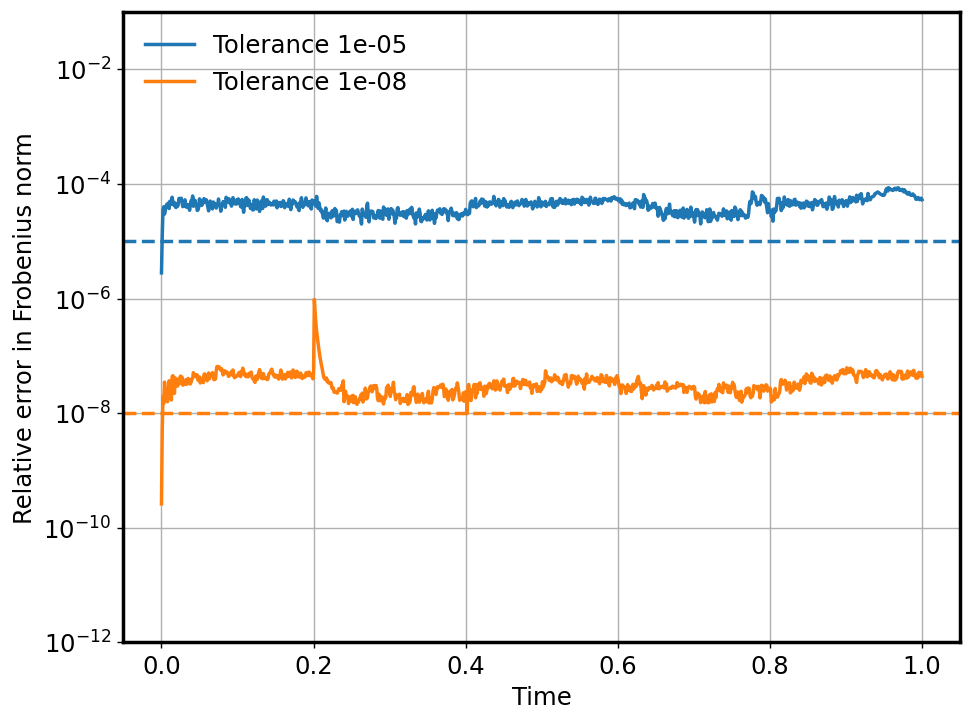

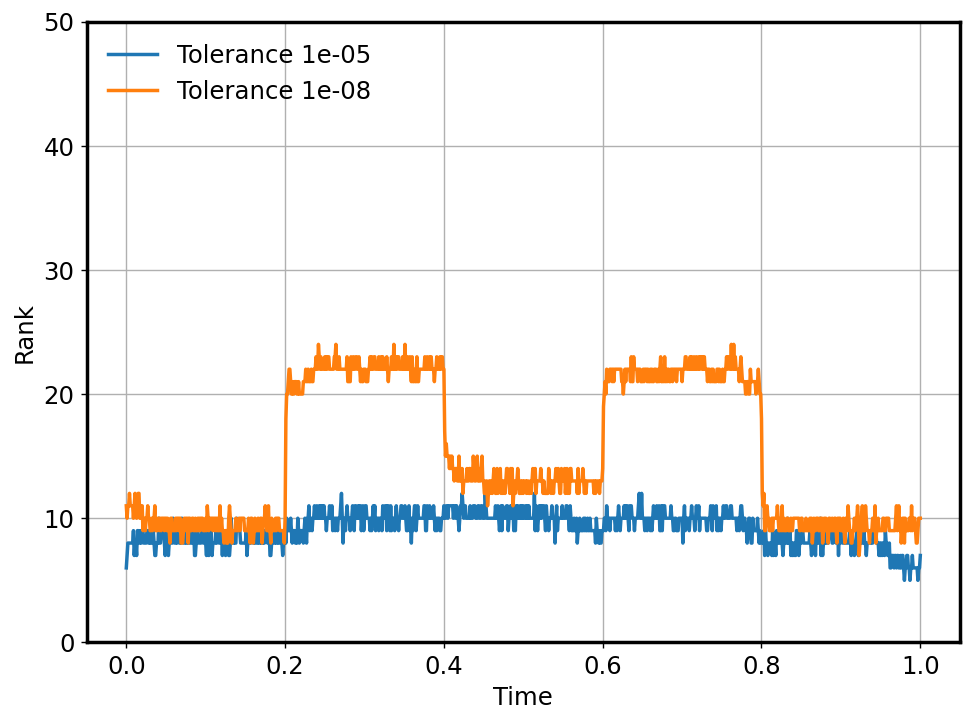

In [9]:
# Plot the error over time
fig1 = plt.figure()
colors = ['tab:blue', 'tab:orange', 'tab:green']
for i in range(len(tolerances)):
    plt.semilogy(ts, errors[:, i], label=f'Tolerance {tolerances[i]}', color=colors[i])
    plt.axhline(tolerances[i], linestyle='--', color=colors[i])
plt.legend(loc='upper left')
plt.xlabel("Time")
plt.ylabel("Relative error in Frobenius norm")
plt.ylim(1e-12, 1e-1)
plt.grid()
plt.tight_layout()
plt.show()

if do_save:
    timestamp = datetime.datetime.now().strftime("%Y%m%d%H%M%S")
    fig1.savefig(f'figures/lyapunov_adaptive_error_{timestamp}.pdf')

# Plot the rank over time
fig2 = plt.figure()
for i in range(len(tolerances)):
    plt.plot(ts, ranks[:, i], label=f'Tolerance {tolerances[i]}', color=colors[i])
    
plt.legend(loc = 'upper left')
plt.ylim(0, 50)
plt.grid()
plt.xlabel("Time")
plt.ylabel("Rank")
plt.tight_layout()
plt.show()

if do_save:
    timestamp = datetime.datetime.now().strftime("%Y%m%d%H%M%S")
    fig2.savefig(f'figures/lyapunov_adaptive_rank_{timestamp}.pdf')